In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import optuna
import warnings
from dython.nominal import associations
from sklearn.utils import all_estimators
from sklearn.base import clone
import joblib
import os
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, classification_report, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.inspection import permutation_importance
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from optuna.samplers import TPESampler

optuna.logging.set_verbosity(logging.WARNING)
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore", category=ConvergenceWarning)

E:\Anaconda\envs\DataAnalysis\Lib\site-packages\dython\__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution


In [2]:
df = pd.read_csv('final_datasets/enhanced_anxiety_dataset.csv')
# df = pd.read_csv('cleaned_enhanced_anxiety_dataset.csv')
target_column = 'Anxiety Level (1-10)'
df[target_column] = df[target_column].astype('object')

print("Total rows:", df.shape[0])
print("Total columns:", df.shape[1])
print("Target column:", target_column)

Total rows: 11000
Total columns: 19
Target column: Anxiety Level (1-10)


In [3]:
df.head()

,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Smoking,Family History of Anxiety,Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10),Anxiety Level (1-10)
0,29,Female,Artist,6.0,2.7,181,10,Yes,No,10,114,14,4,No,Yes,3,Yes,7,5.0
1,46,Other,Nurse,6.2,5.7,200,8,Yes,Yes,1,62,23,2,Yes,No,2,No,8,3.0
2,64,Male,Other,5.0,3.7,117,4,No,Yes,1,91,28,3,No,No,1,Yes,1,1.0
3,20,Female,Scientist,5.8,2.8,360,6,Yes,No,4,86,17,3,No,No,0,No,1,2.0
4,49,Female,Other,8.2,2.3,247,4,Yes,No,1,98,19,4,Yes,Yes,1,No,3,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                11000 non-null  int64  
 1   Gender                             11000 non-null  object 
 2   Occupation                         11000 non-null  object 
 3   Sleep Hours                        11000 non-null  float64
 4   Physical Activity (hrs/week)       11000 non-null  float64
 5   Caffeine Intake (mg/day)           11000 non-null  int64  
 6   Alcohol Consumption (drinks/week)  11000 non-null  int64  
 7   Smoking                            11000 non-null  object 
 8   Family History of Anxiety          11000 non-null  object 
 9   Stress Level (1-10)                11000 non-null  int64  
 10  Heart Rate (bpm)                   11000 non-null  int64  
 11  Breathing Rate (breaths/min)       11000 non-null  int

In [5]:
df.isnull().sum()

Age                                  0
Gender                               0
Occupation                           0
Sleep Hours                          0
Physical Activity (hrs/week)         0
Caffeine Intake (mg/day)             0
Alcohol Consumption (drinks/week)    0
Smoking                              0
Family History of Anxiety            0
Stress Level (1-10)                  0
Heart Rate (bpm)                     0
Breathing Rate (breaths/min)         0
Sweating Level (1-5)                 0
Dizziness                            0
Medication                           0
Therapy Sessions (per month)         0
Recent Major Life Event              0
Diet Quality (1-10)                  0
Anxiety Level (1-10)                 0
dtype: int64

In [6]:
def unic_columns(data):
    object_columns = data.select_dtypes(include='object').columns
    for column in object_columns:
        print(f"Унікальні значення в колонці: '{column}' : ")
        print(data[column].value_counts())
        print("-" * 50)

unic_columns(df)

Унікальні значення в колонці: 'Gender' : 
Gender
Female    3730
Male      3657
Other     3613
Name: count, dtype: int64
--------------------------------------------------
Унікальні значення в колонці: 'Occupation' : 
Occupation
Musician      892
Artist        888
Student       878
Nurse         861
Chef          858
Doctor        842
Other         840
Freelancer    838
Engineer      833
Scientist     832
Athlete       822
Lawyer        809
Teacher       807
Name: count, dtype: int64
--------------------------------------------------
Унікальні значення в колонці: 'Smoking' : 
Smoking
Yes    5779
No     5221
Name: count, dtype: int64
--------------------------------------------------
Унікальні значення в колонці: 'Family History of Anxiety' : 
Family History of Anxiety
Yes    5847
No     5153
Name: count, dtype: int64
--------------------------------------------------
Унікальні значення в колонці: 'Dizziness' : 
Dizziness
Yes    5672
No     5328
Name: count, dtype: int64
----------------

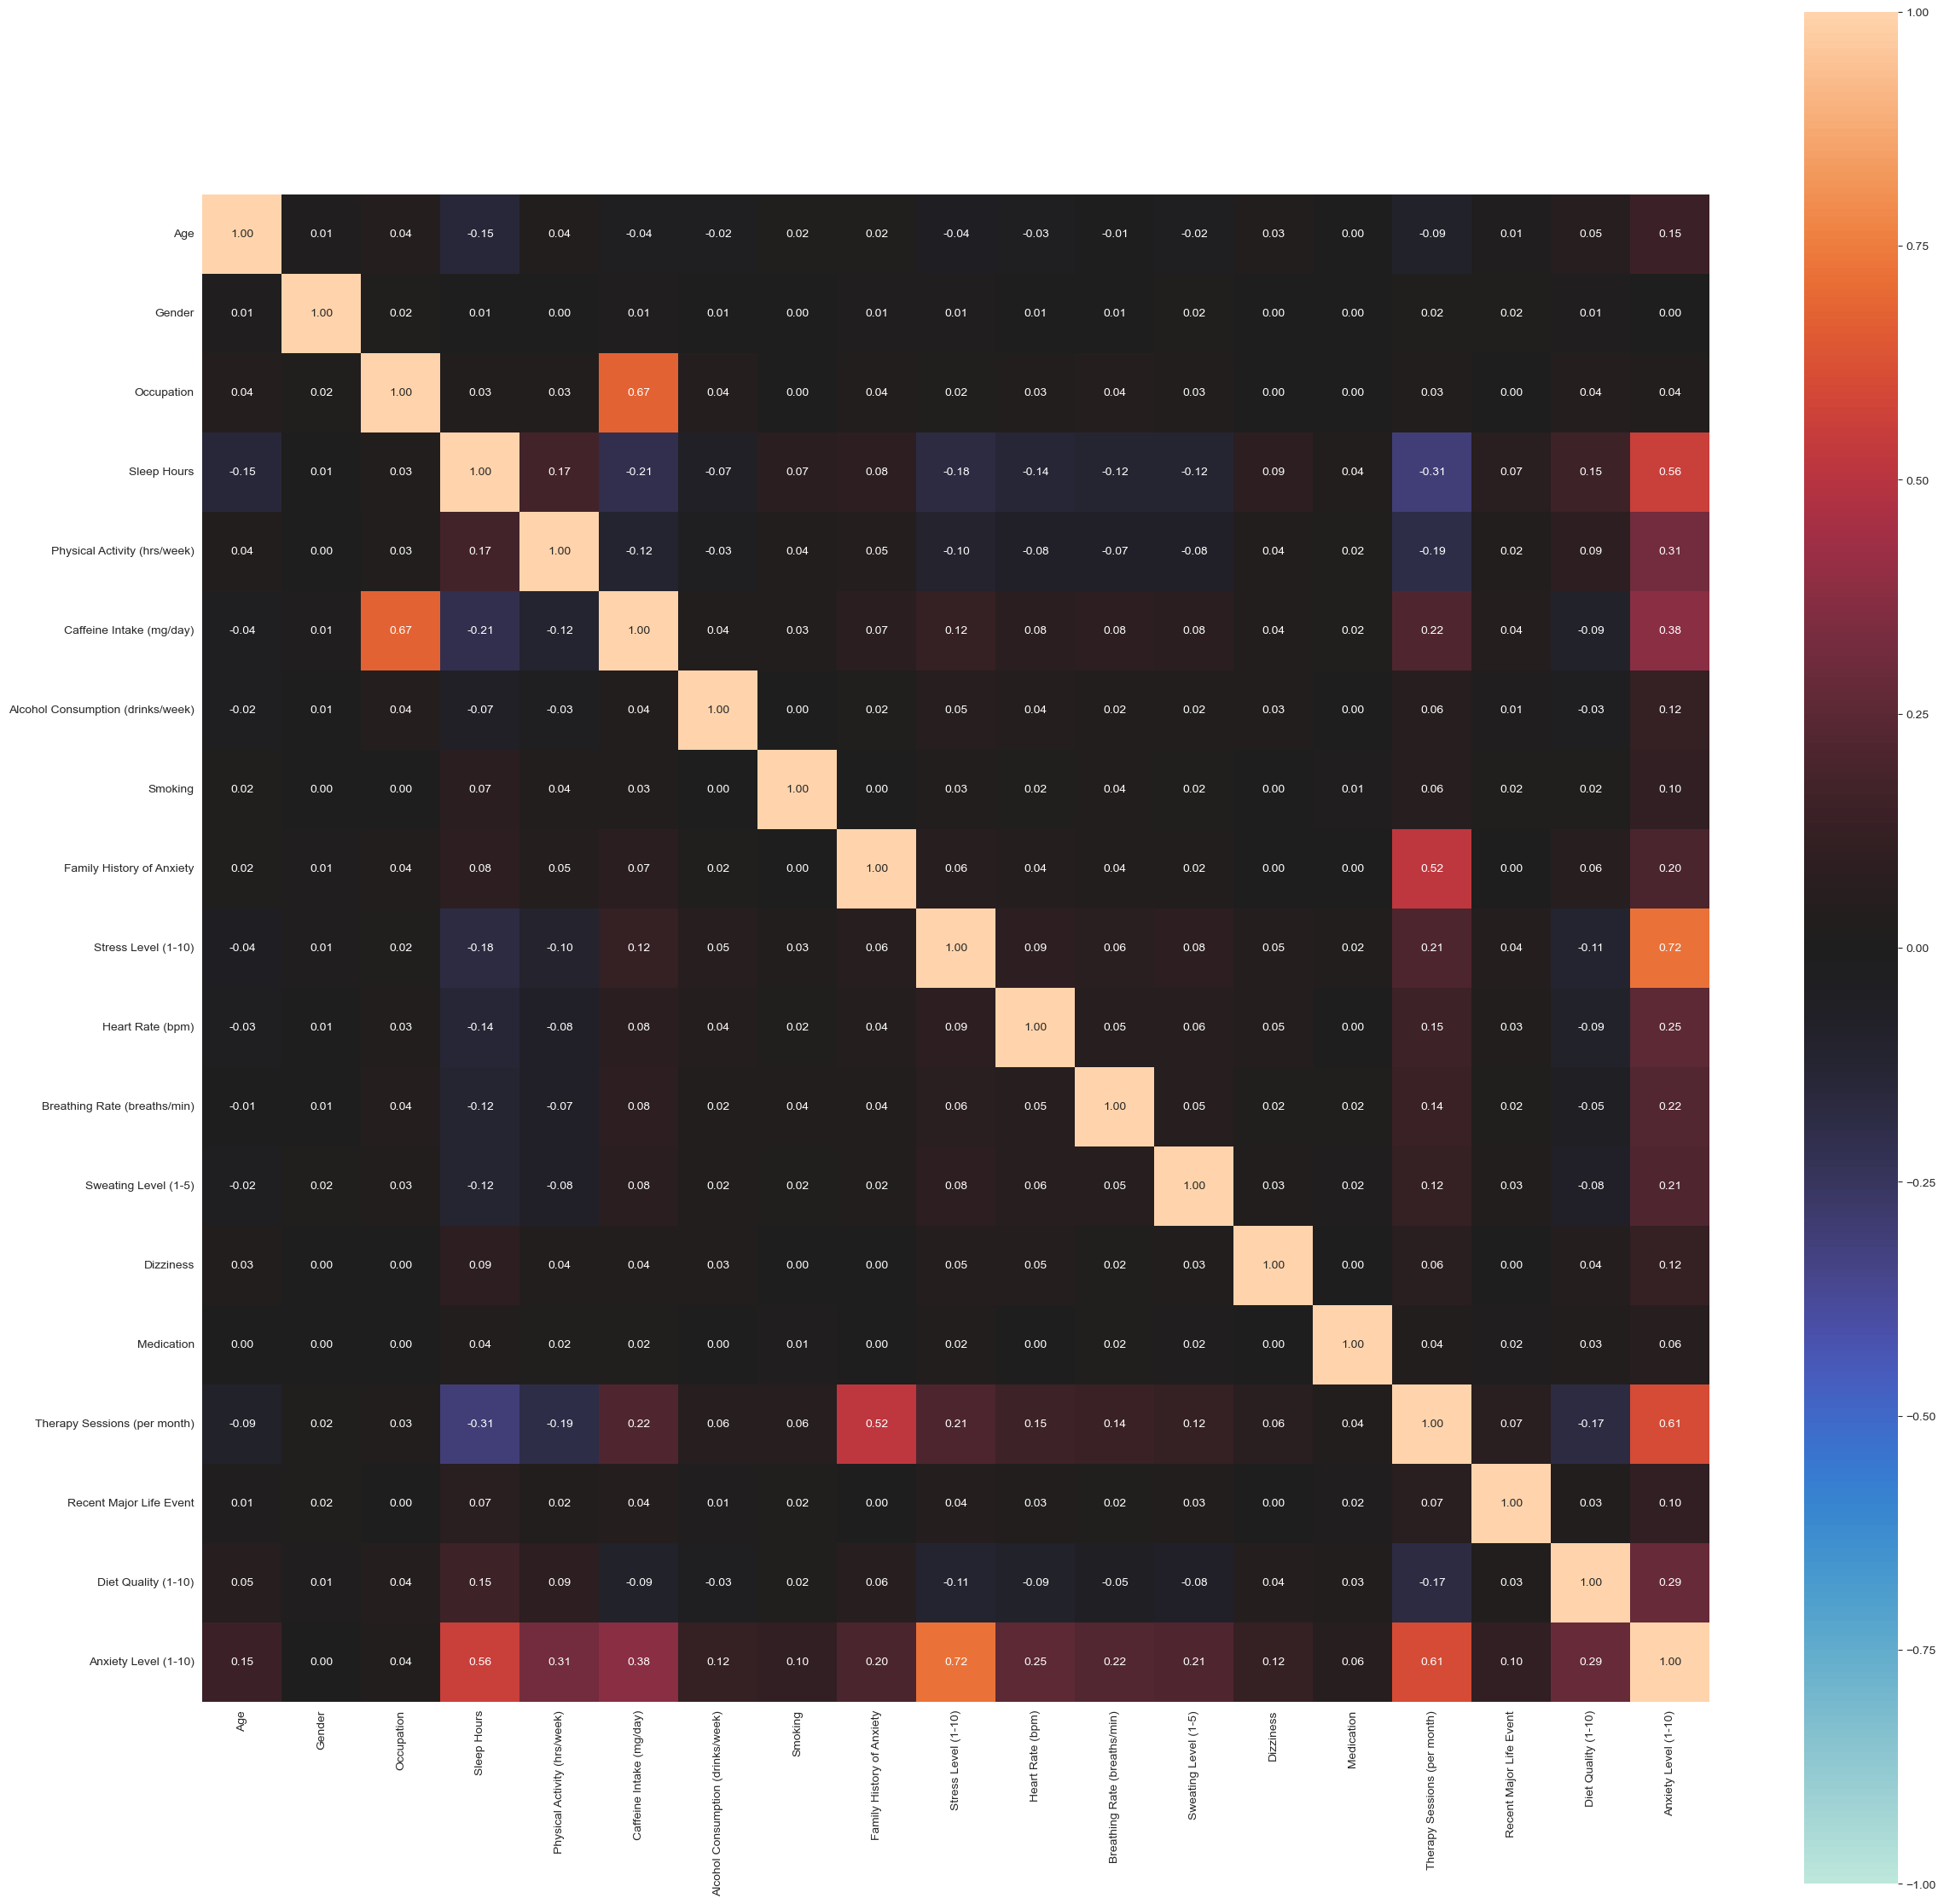

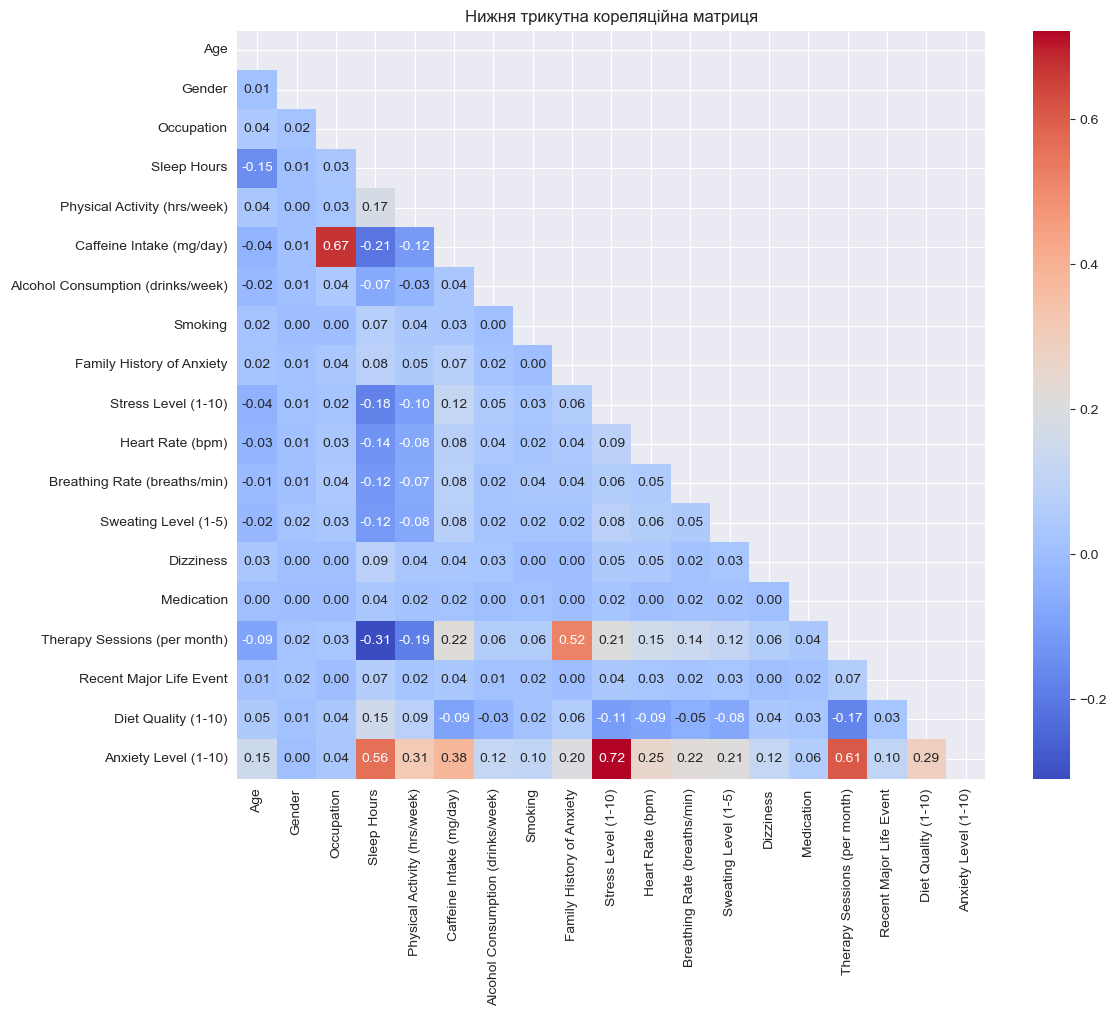


Висококорельовані пари ознак:

Коефіцієнт кореляції відносно цільового поля Anxiety Level (1-10)
                                   Correlations
Anxiety Level (1-10)                   1.000000
Stress Level (1-10)                    0.722448
Therapy Sessions (per month)           0.607668
Sleep Hours                            0.557664
Caffeine Intake (mg/day)               0.380886
Physical Activity (hrs/week)           0.313165
Diet Quality (1-10)                    0.288977
Heart Rate (bpm)                       0.253507
Breathing Rate (breaths/min)           0.219793
Sweating Level (1-5)                   0.213856
Family History of Anxiety              0.195934
Age                                    0.145686
Dizziness                              0.121375
Alcohol Consumption (drinks/week)      0.121077
Smoking                                0.104605
Recent Major Life Event                0.103318
Medication                             0.061205
Occupation                            

In [7]:
def corr_dif(data, threshold=0.85):
    correlation_matrix = associations(data)
    
    def plot_lower_triangle_corr_matrix(corr_matrix):
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        plt.figure(figsize=(12, 10))  
        sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', square=True)
        plt.title("Нижня трикутна кореляційна матриця")
        plt.tight_layout()
        plt.savefig('corr_matrix.png', dpi=300)
        plt.show()
        
    plot_lower_triangle_corr_matrix(correlation_matrix['corr'])
    
    def get_highly_correlated_pairs(corr_matrix, threshold=0.85):
        corr_pairs = []
        cols = corr_matrix.columns
        for i in range(len(cols)):
            for j in range(i):
                corr_value = corr_matrix.iloc[i, j]
                if abs(corr_value) >= threshold:
                    corr_pairs.append((cols[i], cols[j], corr_value))
        return sorted(corr_pairs, key=lambda x: -abs(x[2]))
    
    highly_correlated_pairs = get_highly_correlated_pairs(correlation_matrix['corr'], threshold)
    
    print("\nВисококорельовані пари ознак:")
    for col1, col2, value in highly_correlated_pairs:
        print(f"{col1} - {col2} --> кореляція {value:.2f}")
        
    target_correlations = correlation_matrix['corr'].iloc[:, -1]
    target_col = target_correlations.name
    
    corr_df = target_correlations.to_frame()
    corr_df.columns = ['Correlations']
    corr_df['Abs Correlation'] = corr_df['Correlations'].abs()
    sorted_corr_df = corr_df.sort_values(by='Abs Correlation', ascending=False)
    sorted_corr_df = sorted_corr_df.drop(columns=['Abs Correlation'])
    print(f"\nКоефіцієнт кореляції відносно цільового поля {target_col}")
    pd.set_option('display.max_rows', None)
    print(sorted_corr_df)
    
    return correlation_matrix

correlation_result = corr_dif(df, 0.8)

In [8]:
df_2 = df.copy()

In [9]:
target_original = 'Anxiety Level (1-10)'
def categorize_anxiety(level):
    level = int(level) if isinstance(level, str) else level
    if level <= 4:
        return 'Low'
    elif 4 < level <= 7:
        return 'Medium'
    else: 
        return 'High'

df['Anxiety Class'] = df[target_original].apply(categorize_anxiety).astype('category')
target_col = 'Anxiety Class'
df = df.drop(columns=[target_original])

numeric_cols = df.select_dtypes(include='number').columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

if target_col in categorical_cols:
    categorical_cols.remove(target_col)

print(f"Числові колонки ({len(numeric_cols)}): {numeric_cols}")
print(f"Категоріальні колонки ({len(categorical_cols)}): {categorical_cols}")
print(f"Цільова змінна: {target_col}")

Числові колонки (11): ['Age', 'Sleep Hours', 'Physical Activity (hrs/week)', 'Caffeine Intake (mg/day)', 'Alcohol Consumption (drinks/week)', 'Stress Level (1-10)', 'Heart Rate (bpm)', 'Breathing Rate (breaths/min)', 'Sweating Level (1-5)', 'Therapy Sessions (per month)', 'Diet Quality (1-10)']
Категоріальні колонки (7): ['Gender', 'Occupation', 'Smoking', 'Family History of Anxiety', 'Dizziness', 'Medication', 'Recent Major Life Event']
Цільова змінна: Anxiety Class


створюжм 3 датасети на кожен клас і в них визначаємо аутлаєри (95% варіансу має пояснення) і за допомогою Isolation forest видаляємо аутлаєри, далі цих три датасети конкатенуємо назад в один, також візуалізувати три кластери з цими класами

In [10]:
label_encoders = {}
df_encoded = df.copy()

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    print(f"Закодовано {col}: {len(le.classes_)} унікальних значень")

le_y = LabelEncoder()
y = le_y.fit_transform(df[target_col])
print(f"\nКласи цільової змінної: {le_y.classes_}")
print(f"Розподіл класів: {np.bincount(y)}")

Закодовано Gender: 3 унікальних значень
Закодовано Occupation: 13 унікальних значень
Закодовано Smoking: 2 унікальних значень
Закодовано Family History of Anxiety: 2 унікальних значень
Закодовано Dizziness: 2 унікальних значень
Закодовано Medication: 2 унікальних значень
Закодовано Recent Major Life Event: 2 унікальних значень

Класи цільової змінної: ['High' 'Low' 'Medium']
Розподіл класів: [1014 7618 2368]


In [11]:
scaler = StandardScaler()
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])

print("Масштабування числових ознак завершено")
print(f"Середнє значення після масштабування:\n{df_encoded[numeric_cols].mean()}")
print(f"\nСтандартне відхилення після масштабування:\n{df_encoded[numeric_cols].std()}")

Масштабування числових ознак завершено
Середнє значення після масштабування:
Age                                 -1.395248e-16
Sleep Hours                         -1.007679e-16
Physical Activity (hrs/week)        -7.363807e-17
Caffeine Intake (mg/day)             1.740830e-16
Alcohol Consumption (drinks/week)   -1.085193e-16
Stress Level (1-10)                 -3.681903e-17
Heart Rate (bpm)                     1.847411e-16
Breathing Rate (breaths/min)         2.280196e-16
Sweating Level (1-5)                -1.508288e-16
Therapy Sessions (per month)         5.684342e-17
Diet Quality (1-10)                  2.906766e-17
dtype: float64

Стандартне відхилення після масштабування:
Age                                  1.000045
Sleep Hours                          1.000045
Physical Activity (hrs/week)         1.000045
Caffeine Intake (mg/day)             1.000045
Alcohol Consumption (drinks/week)    1.000045
Stress Level (1-10)                  1.000045
Heart Rate (bpm)                     1

In [12]:
# # from sklearn.ensemble import IsolationForest
# # 
# # df_cleaned_list = []
# # contamination_rate = 0.05
# # 
# # for class_label in np.unique(y):
# #     class_mask = (y == class_label)
# #     X_class = df_encoded.drop(columns=[target_col])[class_mask]
# #     y_class = y[class_mask]
# #     
# #     iso = IsolationForest(contamination=contamination_rate, random_state=42)
# #     outlier_preds = iso.fit_predict(X_class)
# #     
# #     X_class_cleaned = X_class[outlier_preds == 1]
# #     y_class_cleaned = y_class[outlier_preds == 1]
# #     
# #     temp_df = X_class_cleaned.copy()
# #     temp_df[target_col] = y_class_cleaned
# #     df_cleaned_list.append(temp_df)
# #     
# #     print(f"Клас '{le_y.classes_[class_label]}': видалено {sum(outlier_preds == -1)} аутлаєрів")
# # 
# # df_final_cleaned = pd.concat(df_cleaned_list, axis=0).sample(frac=1, random_state=42)
# # df_final_cleaned.to_csv('final_cleaned.csv', index=False)
# # X = df_final_cleaned.drop(columns=[target_col])
# # y = df_final_cleaned[target_col].values
# # from imblearn.under_sampling import EditedNearestNeighbors
# # X_full = df_encoded.drop(columns=[target_col])
# # y_full = y # використовуємо вже закодований y
# 
# # print(f"Початкова кількість записів: {len(X_full)}")
# 
# # 2. Використовуємо алгоритм сімейства Nearest Neighbors для видалення аутлаєрів
# # EditedNearestNeighbors видаляє зразки, чий клас відрізняється від більшості сусідів.
# # Це ідеально підходить для очищення "шуму" та аутлаєрів на межах.
# # enn = EditedNearestNeighbors(n_neighbors=3)
# # X_resampled, y_resampled = enn.fit_resample(X_full, y_full)
# 
# # Оскільки ENN видаляє стільки, скільки вважає за потрібне, перевіримо результат
# # print(f"Кількість записів після ENN: {len(X_resampled)}")
# # print(f"Видалено всього: {len(X_full) - len(X_resampled)} рядків")
# 
# # 3. Якщо вам потрібно видалити СТРОГО 5% (як ви просили раніше)
# # Nearest Neighbors не гарантує фіксований відсоток, але він набагато точніше 
# # знаходить аномалії в ненормальному розподілі, ніж статистичні методи.
# 
# # 4. Формуємо фінальний очищений датасет
# # df_final_cleaned = X_resampled.copy()
# # df_final_cleaned[target_col] = y_resampled
# # 
# # # Перемішуємо дані
# # df_final_cleaned = df_final_cleaned.sample(frac=1, random_state=42)
# # 
# # # Оновлюємо змінні для навчання
# # X = df_final_cleaned.drop(columns=[target_col])
# # y = df_final_cleaned[target_col].values
# # X = df_encoded.drop(columns=[target_col])
# 
from sklearn.neighbors import NearestNeighbors

# 1. Підготовка даних
X_full = df_encoded.drop(columns=[target_col])
y_full = y

# 2. Реалізація логіки Edited Nearest Neighbors (ENN) вручну
n_neighbors = 3
nn = NearestNeighbors(n_neighbors=n_neighbors + 1) 
nn.fit(X_full)

distances, indices = nn.kneighbors(X_full)

keep_mask = []
for i in range(len(X_full)):
    neighbor_indices = indices[i][1:]
    neighbor_classes = y_full[neighbor_indices]
    most_common_neighbor_class = np.bincount(neighbor_classes).argmax()

    if y_full[i] == most_common_neighbor_class:
        keep_mask.append(True)
    else:
        keep_mask.append(False)

keep_mask = np.array(keep_mask)

# 3. Формуємо очищений датасет
X_resampled = X_full[keep_mask].copy()
y_resampled = y_full[keep_mask]

print(f"Початкова кількість записів: {len(X_full)}")
print(f"Видалено 'шумних' точок (NN-outliers): {len(X_full) - len(X_resampled)}")

# --- НОВИЙ БЛОК: ДЕКОДУВАННЯ ПЕРЕД ЗБЕРЕЖЕННЯМ ---
df_save = X_resampled.copy()

# 1. Дестандартизація числових ознак
if 'scaler' in globals() and 'numeric_cols' in globals():
    df_save[numeric_cols] = scaler.inverse_transform(df_save[numeric_cols])

# 2. Декодування категорійних ознак
if 'label_encoders' in globals() and 'categorical_cols' in globals():
    for col in categorical_cols:
        if col in label_encoders and col in df_save.columns:
            df_save[col] = label_encoders[col].inverse_transform(df_save[col].astype(int))

# 3. Декодування цільової змінної
df_save[target_col] = le_y.inverse_transform(y_resampled)

# Перемішуємо та зберігаємо "чистий" CSV
df_save = df_save.sample(frac=1, random_state=42)
df_save.to_csv('anxiety_dataset_enn.csv', index=False)
print("✅ Очищений та декодований датасет збережено в 'anxiety_dataset_enn.csv'")

# --- ПІДГОТОВКА ДЛЯ ПОДАЛЬШОГО МОДЕЛЮВАННЯ ---
# Для навчання нам все ще потрібні цифри, тому використовуємо X_resampled та y_resampled
X = X_resampled
y = y_resampled # залишаємо як числа для моделей

n_classes = len(np.unique(y))
is_multiclass = n_classes > 2

print(f"Кількість класів: {n_classes}")
print(f"Мультикласова класифікація: {is_multiclass}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nРозмір тренувальної вибірки: {X_train.shape}")
print(f"Розмір тестової вибірки: {X_test.shape}")
# np.bincount працює лише з цілими числами
print(f"Розподіл класів у тренувальній вибірці: {np.bincount(y_train)}")
print(f"Розподіл класів у тестовій вибірці: {np.bincount(y_test)}")

Початкова кількість записів: 11000
Видалено 'шумних' точок (NN-outliers): 2413
✅ Очищений та декодований датасет збережено в 'anxiety_dataset_enn.csv'
Кількість класів: 3
Мультикласова класифікація: True

Розмір тренувальної вибірки: (6869, 18)
Розмір тестової вибірки: (1718, 18)
Розподіл класів у тренувальній вибірці: [ 800 5375  694]
Розподіл класів у тестовій вибірці: [ 200 1344  174]


In [13]:
X = X_resampled
y = y_resampled # залишаємо як числа для моделей

n_classes = len(np.unique(y))
is_multiclass = n_classes > 2

print(f"Кількість класів: {n_classes}")
print(f"Мультикласова класифікація: {is_multiclass}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nРозмір тренувальної вибірки: {X_train.shape}")
print(f"Розмір тестової вибірки: {X_test.shape}")
# np.bincount працює лише з цілими числами
print(f"Розподіл класів у тренувальній вибірці: {np.bincount(y_train)}")
print(f"Розподіл класів у тестовій вибірці: {np.bincount(y_test)}")

Кількість класів: 3
Мультикласова класифікація: True

Розмір тренувальної вибірки: (6869, 18)
Розмір тестової вибірки: (1718, 18)
Розподіл класів у тренувальній вибірці: [ 800 5375  694]
Розподіл класів у тестовій вибірці: [ 200 1344  174]


In [41]:
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score, f1_score, make_scorer

classifiers = all_estimators(type_filter='classifier')
skip_models = ['GaussianProcessClassifier']
results = {}

print(f"Тестування різних класифікаторів з кросвалідацією (5 фолдів)")
print("=" * 80)

CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

precision_scorer = make_scorer(precision_score, average='macro', zero_division=0)
recall_scorer = make_scorer(recall_score, average='macro', zero_division=0)
f1_scorer = make_scorer(f1_score, average='macro', zero_division=0)
for name, ClassifierClass in classifiers:
    if name in skip_models:
        continue 
    try:
        model = ClassifierClass()
        scores = cross_val_score(model, X_train, y_train, cv=CV, scoring='precision_macro', n_jobs=-1)
        r_scores = cross_val_score(model, X_train, y_train, cv=CV, scoring=recall_scorer, n_jobs=-1)
        f1_scores = cross_val_score(model, X_train, y_train, cv=CV, scoring=f1_scorer, n_jobs=-1)
        model.fit(X_train, y_train)
        
        roc_auc = np.nan
        if hasattr(model, 'predict_proba'):
            pred_proba = model.predict_proba(X_train)
            if is_multiclass:
                if pred_proba.ndim == 2 and pred_proba.shape[1] == n_classes:
                    roc_auc = roc_auc_score(y_train, pred_proba, multi_class='ovr')
                else:
                    roc_auc = np.nan
            else:
                if pred_proba.ndim == 2 and pred_proba.shape[1] == 2:
                    roc_auc = roc_auc_score(y_train, pred_proba[:, 1])
                elif pred_proba.ndim == 1:
                    roc_auc = roc_auc_score(y_train, pred_proba)
                else:
                    roc_auc = np.nan
        elif hasattr(model, 'decision_function'): 
            pred_score = model.decision_function(X_train)
            if is_multiclass:
                if pred_score.ndim == 2 and pred_score.shape[1] == n_classes:
                    roc_auc = roc_auc_score(y_train, pred_score, multi_class='ovr')
                else:
                    roc_auc = np.nan
            else:
                if pred_score.ndim == 1:
                    roc_auc = roc_auc_score(y_train, pred_score)
                elif pred_score.ndim == 2 and pred_score.shape[1] == 2:
                    roc_auc = roc_auc_score(y_train, pred_score[:, 1])
                else:
                    roc_auc = np.nan
        else:
            roc_auc = np.nan
            
        if not np.isnan(scores.mean()):
            results[name] = {
                'mean_precision': scores.mean(),
                'mean recall': r_scores.mean(),
                'mean f1': f1_scores.mean(),
                'std_dev': scores.std(),
                'roc_auc': roc_auc,
            }
            print(f"{name}: MEAN PRECISION {scores.mean():.3f},Mean recall{r_scores.mean()} ,mean F1: {f1_scores.mean()}, STD (± {scores.std():.3f}), ROC AUC: {roc_auc:.3f}")
        else:
            print(f"{name}: Пропущено через NaN у результаті") 

    except Exception as e:
        continue
       
sorted_results = sorted(results.items(), key=lambda x: x[1]['mean_precision'], reverse=True)

print("\nТоп-10 найбільш точних моделей:")
for i, (name, metric) in enumerate(sorted_results[:10], 1):
    print(f"{i:2d}. {name:40s} | MeanPrecision(macro): {metric['mean_precision']:.3f}|Mean Recall{metric['mean recall']} | Mean F1{metric['mean f1']} (± {metric['std_dev']:.3f}) | ROC-AUC: {metric['roc_auc']:.3f}")
    
results_df = pd.DataFrame.from_dict(results, orient='index')

Тестування різних класифікаторів з кросвалідацією (5 фолдів)
AdaBoostClassifier: MEAN PRECISION 0.853,Mean recall0.8430767596236459 ,mean F1: 0.8459528986514406, STD (± 0.017), ROC AUC: 0.945
BaggingClassifier: MEAN PRECISION 0.888,Mean recall0.8433414293842985 ,mean F1: 0.862254983760341, STD (± 0.019), ROC AUC: 1.000
BernoulliNB: MEAN PRECISION 0.818,Mean recall0.7098678096956207 ,mean F1: 0.7217987870847675, STD (± 0.019), ROC AUC: 0.956
CalibratedClassifierCV: MEAN PRECISION 0.890,Mean recall0.8321928455213585 ,mean F1: 0.8545415131113543, STD (± 0.011), ROC AUC: 0.972
DecisionTreeClassifier: MEAN PRECISION 0.822,Mean recall0.8275377004766258 ,mean F1: 0.8271087348496458, STD (± 0.009), ROC AUC: 1.000
DummyClassifier: MEAN PRECISION 0.261,Mean recall0.3333333333333333 ,mean F1: 0.29266035845852334, STD (± 0.000), ROC AUC: 0.500
ExtraTreeClassifier: MEAN PRECISION 0.771,Mean recall0.7622123807526274 ,mean F1: 0.7588199952649892, STD (± 0.016), ROC AUC: 1.000
ExtraTreesClassifier: ME


🚀 ТОП-5 моделей для ансамблів:
KNeighborsClassifier | Precision (mean) = 0.922
LabelPropagation     | Precision (mean) = 0.916
LabelSpreading       | Precision (mean) = 0.916
ExtraTreesClassifier | Precision (mean) = 0.914
RandomForestClassifier | Precision (mean) = 0.905

⚙️ Навчання Voting Classifier...
⚙️ Навчання Stacking Classifier...

Метрика (Macro)      | Voting     | Stacking  
---------------------------------------------
Precision            | 0.938      | 0.939
Recall               | 0.886      | 0.908
F1                   | 0.908      | 0.922

📊 ДЕТАЛЬНИЙ ЗВІТ ПО КЛАСАХ (Stacking):
              precision    recall  f1-score   support

        High       1.00      1.00      1.00       200
         Low       0.97      0.98      0.97      1344
      Medium       0.85      0.74      0.79       174

    accuracy                           0.96      1718
   macro avg       0.94      0.91      0.92      1718
weighted avg       0.96      0.96      0.96      1718



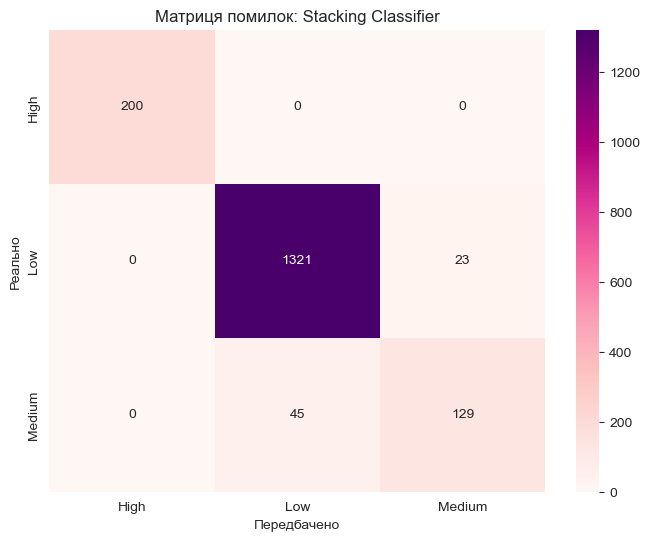

In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. ПІДГОТОВКА МОДЕЛЕЙ ---

# Беремо ТОП-5 результатів попереднього тестування
top5 = sorted_results[:5]
print("\n🚀 ТОП-5 моделей для ансамблів:")
for name, metric in top5:
    print(f"{name:<20} | Precision (mean) = {metric['mean_precision']:.3f}")

def instantiate_model(model_name):
    """Функція для створення об'єкта моделі за назвою"""
    for name, Classifier in classifiers:
        if name == model_name:
            try:
                # Передаємо random_state, якщо модель це підтримує
                return Classifier(random_state=42)
            except:
                return Classifier()
    return None

# Формуємо список кортежів для ансамблів
top_models = []
for name, metric in top5:
    model_obj = instantiate_model(name)
    if model_obj is not None:
        top_models.append((name, model_obj))

# --- 2. VOTING CLASSIFIER (М'яке голосування) ---

print("\n⚙️ Навчання Voting Classifier...")
voting_model = VotingClassifier(
    estimators=top_models,
    voting='soft'  # Використовуємо ймовірності класів
)

voting_model.fit(X_train, y_train)
y_pred_vote = voting_model.predict(X_test)

# Розрахунок метрик для Voting
metrics_vote = {
    "Precision": precision_score(y_test, y_pred_vote, average="macro", zero_division=0),
    "Recall": recall_score(y_test, y_pred_vote, average="macro", zero_division=0),
    "F1": f1_score(y_test, y_pred_vote, average="macro", zero_division=0)
}

# --- 3. STACKING CLASSIFIER ---

print("⚙️ Навчання Stacking Classifier...")
stacked_model = StackingClassifier(
    estimators=top_models,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5  # Крос-валідація для мета-моделі
)

stacked_model.fit(X_train, y_train)
y_pred_stack = stacked_model.predict(X_test)

# Розрахунок метрик для Stacking
metrics_stack = {
    "Precision": precision_score(y_test, y_pred_stack, average="macro", zero_division=0),
    "Recall": recall_score(y_test, y_pred_stack, average="macro", zero_division=0),
    "F1": f1_score(y_test, y_pred_stack, average="macro", zero_division=0)
}

# --- 4. ПОРІВНЯННЯ ТА ЗВІТИ ---

print("\n" + "="*40)
print(f"{'Метрика (Macro)':<20} | {'Voting':<10} | {'Stacking':<10}")
print("-" * 45)
for m in ["Precision", "Recall", "F1"]:
    print(f"{m:<20} | {metrics_vote[m]:.3f}      | {metrics_stack[m]:.3f}")
print("="*40)

# Висновок детального звіту для Stacking (зазвичай він кращий)
print("\n📊 ДЕТАЛЬНИЙ ЗВІТ ПО КЛАСАХ (Stacking):")
# le_y.classes_ містить оригінальні назви: Low, Medium, High
print(classification_report(y_test, y_pred_stack, target_names=le_y.classes_))

# --- 5. ВІЗУАЛІЗАЦІЯ ПОМИЛОК (Confusion Matrix) ---

cm = confusion_matrix(y_test, y_pred_stack)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu', 
            xticklabels=le_y.classes_, yticklabels=le_y.classes_)
plt.title('Матриця помилок: Stacking Classifier')
plt.xlabel('Передбачено')
plt.ylabel('Реально')
plt.show()

In [16]:
param_grids = {
    "QuadraticDiscriminantAnalysis": { #
        'reg_param': [0.0, 0.1, 0.2, 0.3, 0.5, 0.7],
        'store_covariance': [True, False],
        'tol': [1e-4, 1e-3, 1e-2]
    },
    "LinearDiscriminantAnalysis": { #
        'solver': ['svd', 'lsqr', 'eigen'],
        'shrinkage': [None, 'auto', 0.1, 0.3, 0.5, 0.7, 0.9],
        'tol': [1e-4, 1e-3],
    },
    "LogisticRegressionCV": {
        'Cs': [10, 20],
        'max_iter': [1000, 2000, 3000],
        'solver': ['lbfgs', 'liblinear', 'saga'],
        'penalty': ['l2', 'l1'],
        'cv': [3, 5]
    },
    "GaussianNB": { #
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    },
    "MLPClassifier": { #
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam'],
        'alpha': [0.0001, 0.001, 0.01],
        'max_iter': [500, 1000]
    },
    "RandomForestClassifier": { #
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    },
    "GradientBoostingClassifier": { #
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
    },
    "LogisticRegression": { #
        'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
        'max_iter': [1000, 2000],
        'solver': ['lbfgs', 'liblinear', 'saga'],
        'penalty': ['l2', 'l1'],
        'class_weight': [None, 'balanced']
    },
    "ExtraTreesClassifier": { #
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    },
    "CalibratedClassifierCV": {
        'method': ['sigmoid', 'isotonic'],
        'cv': [3, 5]
    },
    "HistGradientBoostingClassifier": { #
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [5, 10, 15, None],
        'max_iter': [100, 200, 300],
        "l2_regularization": [0.0, 1.0, 5.0]
    },
    "AdaBoostClassifier": { #
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.5, 1.0, 1.5],
        'algorithm': ['SAMME', 'SAMME.R']
    },
    "KNeighborsClassifier": { #
        'n_neighbors': [3, 5, 7, 9, 11, 15],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree'],
        'leaf_size': [20, 30, 40, 50],
        'p': [1, 2]
    },
    "DecisionTreeClassifier": { #
        'max_depth': [5, 10, 20, 30, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'criterion': ['gini', 'entropy'],
        'max_features': ['sqrt', 'log2', None]
    }
}

print("Гіперпараметри підготовлені для наступних моделей:")
for model_name in param_grids.keys():
    print(f"  - {model_name}: {len(param_grids[model_name])} параметрів")

Гіперпараметри підготовлені для наступних моделей:
  - QuadraticDiscriminantAnalysis: 3 параметрів
  - LinearDiscriminantAnalysis: 3 параметрів
  - LogisticRegressionCV: 5 параметрів
  - GaussianNB: 1 параметрів
  - MLPClassifier: 5 параметрів
  - RandomForestClassifier: 5 параметрів
  - GradientBoostingClassifier: 3 параметрів
  - LogisticRegression: 5 параметрів
  - ExtraTreesClassifier: 4 параметрів
  - CalibratedClassifierCV: 2 параметрів
  - HistGradientBoostingClassifier: 4 параметрів
  - AdaBoostClassifier: 3 параметрів
  - KNeighborsClassifier: 5 параметрів
  - DecisionTreeClassifier: 5 параметрів


In [17]:
top_10_classifiers = sorted_results[:10]
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
feature_names = X_train.columns
feature_importance_dict = {}
tuned_results = {}

print("Початок підбору гіперпараметрів для Top-10 моделей")
print("=" * 80)

for name, _ in top_10_classifiers:
    print(f"\n{'='*80}")
    print(f"Обробка моделі: {name}")
    print(f"{'='*80}")
    
    ClassifierClass = dict(classifiers)[name]
    base_model = ClassifierClass()
    
    if name in param_grids:
        param_grid = param_grids[name]
        print(f"Підбір гіперпараметрів: {len(param_grid)} параметрів")
        print(f"Параметри: {list(param_grid.keys())}")
        
        try:
            grid_search = GridSearchCV(
                base_model, 
                param_grid, 
                cv=CV, 
                scoring='precision_macro',
                n_jobs=-1,
                verbose=1
            )
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            best_idx = grid_search.best_index_
            mean_score = grid_search.cv_results_['mean_test_score'][best_idx]
            std_score = grid_search.cv_results_['std_test_score'][best_idx]
        except Exception as e:
            print(f"Помилка GridSearch: {e}")
            print("Використовується модель за замовчуванням")
            best_model = base_model
            best_model.fit(X_train, y_train)
            best_params = "Параметри за замовчуванням"
            scores = cross_val_score(best_model, X_train, y_train, cv=CV, scoring='precision_macro', n_jobs=-1)
            mean_score = scores.mean()
            std_score = scores.std()
    else:
        print(f"Гіперпараметри не визначені, використовується модель за замовчуванням")
        best_model = base_model
        best_model.fit(X_train, y_train)
        best_params = "Параметри за замовчуванням"
        scores = cross_val_score(best_model, X_train, y_train, cv=CV, scoring='precision_macro', n_jobs=-1)
        mean_score = scores.mean()
        std_score = scores.std()
    
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    train_accuracy = precision_score(y_train, y_train_pred, average='macro', zero_division=0)
    train_recall = recall_score(y_train, y_train_pred, average='macro', zero_division=0)
    train_f1 = f1_score(y_train, y_train_pred, average='macro', zero_division=0)
    test_accuracy = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, average='macro', zero_division=0)
    
    if hasattr(best_model, 'predict_proba'):
        proba_test = best_model.predict_proba(X_test)
        if is_multiclass:
            if proba_test.ndim == 2 and proba_test.shape[1] == n_classes:
                roc_auc_test = roc_auc_score(y_test, proba_test, multi_class='ovr')
            else:
                roc_auc_test = np.nan
        else:
            if proba_test.ndim == 2 and proba_test.shape[1] == 2:
                roc_auc_test = roc_auc_score(y_test, proba_test[:, 1])
            elif proba_test.ndim == 1:
                roc_auc_test = roc_auc_score(y_test, proba_test)
            else:
                roc_auc_test = np.nan
    elif hasattr(best_model, 'decision_function'):
        proba_test = best_model.decision_function(X_test)
        if is_multiclass:
            if proba_test.ndim == 2 and proba_test.shape[1] == n_classes:
                roc_auc_test = roc_auc_score(y_test, proba_test, multi_class='ovr')
            else:
                roc_auc_test = np.nan
        else:
            if proba_test.ndim == 1:
                roc_auc_test = roc_auc_score(y_test, proba_test)
            elif proba_test.ndim == 2 and proba_test.shape[1] == 2:
                roc_auc_test = roc_auc_score(y_test, proba_test[:, 1])
            else:
                roc_auc_test = np.nan
    else:
        roc_auc_test = np.nan
    
    tuned_results[name] = {
        'best_params': best_params,
        'cv_mean_score': mean_score,
        'cv_std_score': std_score,
        'train precision': train_accuracy,
        'test precision': test_accuracy,
        'train recall': train_recall,
        'test recall': test_recall,
        'train f1': train_f1,
        'test f1': test_f1,
        'roc_auc_test': roc_auc_test,
        'model': best_model
    }
    
    print(f"\n{'─'*80}")
    print(f"Результати для {name}:")
    print(f"{'─'*80}")
    print(f"Найкращі параметри: {best_params}")
    print(f"CV precision_macro: {mean_score:.4f} (± {std_score:.4f})")
    print(f"Train precision: {train_accuracy:.4f}")
    print(f"Test precision: {test_accuracy:.4f}")
    print(f"Train recall: {train_recall:.4f}")
    print(f"Test recall: {test_recall:.4f}")
    print(f"Train F1-score: {train_f1:.4f}")
    print(f"Test F1-score: {test_f1:.4f}")
    print(f"Test ROC-AUC: {roc_auc_test:.4f}")
    
    y_pred_full = best_model.predict(X)
    print(f"\n{'─'*80}")
    print(f"Важливість ознак для {name}:")
    print(f"{'─'*80}")
    
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        feature_importance_dict[name] = importances
        sort_idx = np.argsort(importances)[::-1]
        print("Топ-10 найважливіших ознак:")
        for i, idx in enumerate(sort_idx[:10], 1):
            print(f"{i:2d}. {feature_names[idx]:30s}: {importances[idx]:.4f}")
    else:
        print("Обчислення Permutation Importance...")
        perm_importances = permutation_importance(
            best_model, X_test, y_test, 
            n_repeats=10, 
            random_state=42,
            n_jobs=-1
        )
        importances = perm_importances.importances_mean
        feature_importance_dict[name] = importances
        sort_idx = np.argsort(importances)[::-1]
        print("Топ-10 найважливіших ознак:")
        for i, idx in enumerate(sort_idx[:10], 1):
            print(f"{i:2d}. {feature_names[idx]:30s}: {importances[idx]:.4f}")

print("\n" + "="*80)
print("Підбір гіперпараметрів завершено!")
print("="*80)

Початок підбору гіперпараметрів для Top-10 моделей

Обробка моделі: KNeighborsClassifier
Підбір гіперпараметрів: 5 параметрів
Параметри: ['n_neighbors', 'weights', 'algorithm', 'leaf_size', 'p']
Fitting 5 folds for each of 288 candidates, totalling 1440 fits

────────────────────────────────────────────────────────────────────────────────
Результати для KNeighborsClassifier:
────────────────────────────────────────────────────────────────────────────────
Найкращі параметри: {'algorithm': 'auto', 'leaf_size': 20, 'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
CV precision_macro: 0.9445 (± 0.0150)
Train precision: 1.0000
Test precision: 0.9354
Train recall: 1.0000
Test recall: 0.7366
Train F1-score: 1.0000
Test F1-score: 0.7609
Test ROC-AUC: 0.9717

────────────────────────────────────────────────────────────────────────────────
Важливість ознак для KNeighborsClassifier:
────────────────────────────────────────────────────────────────────────────────
Обчислення Permutation Importance.

In [18]:
def suggest_params(trial, model_name):
    if model_name == "QuadraticDiscriminantAnalysis":
        reg_param = trial.suggest_loguniform('reg_param', 1e-4, 0.7) 
        store_covariance = trial.suggest_categorical('store_covariance', [True, False])
        tol = trial.suggest_categorical('tol', [1e-4, 1e-3, 1e-2])
        
        return {
            'reg_param': reg_param,
            'store_covariance': store_covariance,
            'tol': tol
        }
    elif model_name == "LinearDiscriminantAnalysis":
        solver = trial.suggest_categorical('solver', ['svd', 'lsqr', 'eigen'])
        params = {'solver': solver}
        if solver in ['lsqr', 'eigen']:
            params['shrinkage'] = trial.suggest_categorical('shrinkage', ['auto',  0.1, 0.3, 0.5, 0.7, 0.9])
            params['tol'] = trial.suggest_categorical('tol', [1e-4, 1e-3])  
        return params
        
    elif model_name == "LogisticRegression":
        solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga'])
        
        if solver == 'lbfgs':
            penalty = 'l2'
        elif solver in ['liblinear', 'saga']:
            penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
        else:
            penalty = 'l2' 
            
        C = trial.suggest_float('C', 0.001, 100.0, log=True)
        max_iter = trial.suggest_int('max_iter', 1000, 3000)
        class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
        return {'solver': solver, 'penalty': penalty, 'C': C, 'max_iter': max_iter, 'class_weight': class_weight}
        
    elif model_name == "GaussianNB":
        var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-9, 1e-5)
        return {'var_smoothing': var_smoothing}
        
    elif model_name == "MLPClassifier":
        hidden_layer_sizes_choice = trial.suggest_categorical('hidden_layer_sizes_choice', ['small', 'medium', 'large'])
        if hidden_layer_sizes_choice == 'small':
            hidden_layer_sizes = (50,)
        elif hidden_layer_sizes_choice == 'medium':
            hidden_layer_sizes = (100,)
        else:
            hidden_layer_sizes = (50, 50) 
            
        activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
        alpha = trial.suggest_loguniform('alpha', 0.0001, 0.01)
        max_iter = trial.suggest_int('max_iter', 500, 1000)
        solver = trial.suggest_categorical('solver', ['adam'])
        
        return {
            'hidden_layer_sizes': hidden_layer_sizes,
            'activation': activation,
            'alpha': alpha,
            'max_iter': max_iter,
            'solver': solver
        }
        
    elif model_name in ["RandomForestClassifier", "ExtraTreesClassifier"]:
        n_estimators = trial.suggest_int('n_estimators', 100, 300)
        max_depth = trial.suggest_categorical('max_depth', [10, 20, None])
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
        
        return {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'max_features': max_features
        }
        
    elif model_name == "GradientBoostingClassifier":
        n_estimators = trial.suggest_int('n_estimators', 100, 300)
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
        max_depth = trial.suggest_int('max_depth', 3, 7)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
        
        return {
            'n_estimators': n_estimators,
            'learning_rate': learning_rate,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf
        }
        
    elif model_name == "HistGradientBoostingClassifier":
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.1)
        max_depth = trial.suggest_categorical('max_depth', [5, 10, 15, None])
        max_iter = trial.suggest_int('max_iter', 100, 300)
        l2_regularization = trial.suggest_loguniform('l2_regularization', 0.001, 5.0)
        
        return {
            'learning_rate': learning_rate,
            'max_depth': max_depth,
            'max_iter': max_iter,
            'l2_regularization': l2_regularization
        }

    elif model_name == "AdaBoostClassifier":
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1.5)
        algorithm = trial.suggest_categorical('algorithm', ['SAMME', 'SAMME.R'])
        
        return {
            'n_estimators': n_estimators,
            'learning_rate': learning_rate,
            'algorithm': algorithm
        }
        
    elif model_name == "KNeighborsClassifier":
        n_neighbors = trial.suggest_int('n_neighbors', 3, 15)
        weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
        algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree'])
        p = trial.suggest_int('p', 1, 2)
        leaf_size = trial.suggest_int('leaf_size', 20, 50)
        
        return {
            'n_neighbors': n_neighbors,
            'weights': weights,
            'algorithm': algorithm,
            'p': p,
            'leaf_size': leaf_size
        }
        
    elif model_name == "DecisionTreeClassifier":
        max_depth = trial.suggest_categorical('max_depth', [5, 10, 20, 30, None])
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 8)
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
        
        return {
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'criterion': criterion,
            'max_features': max_features
        }
    
    elif model_name == "LogisticRegressionCV":
        solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga'])
        Cs_count = trial.suggest_int('Cs', 5, 30) 
        
        if solver == 'lbfgs' :
            penalty = 'l2' 
        elif solver in ['liblinear', 'saga']:
            penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
        else:
            penalty = 'l2' 
            
        max_iter = trial.suggest_int('max_iter', 1000, 3000)
        class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
        cv_inner = trial.suggest_categorical('cv', [3, 5, 7])
        
        params = {
            'solver': solver,
            'penalty': penalty,
            'Cs': Cs_count,
            'max_iter': max_iter,
            'class_weight': class_weight,
            'cv': cv_inner
        }
        
        return params
        
    return {} 
    
classifiers_dict = dict(all_estimators(type_filter='classifier'))

def objective(trial, model_name, X_train, y_train, CV, classifiers_dict):
    try:
        params = suggest_params(trial, model_name)
    except ValueError:
        return 0.0
    
    if model_name not in classifiers_dict:
        return 0.0

    ClassifierClass = classifiers_dict[model_name]
    try:
        model = ClassifierClass(**params, random_state=42)
    except (ValueError, TypeError):
        return 0.0

    try:
        scores = cross_val_score(model, X_train, y_train, cv=CV, scoring='precision_macro', n_jobs=-1)
        mean_precision = scores.mean()
        if np.isnan(mean_precision):
            return 0.0
        return mean_precision
        
    except Exception as e:
        return 0.0
    
top_10_classifiers_names = [name for name, _ in sorted_results[:10]] 
tuned_results_optuna = {}
N_TRIALS = 50 

print("Початок підбору гіперпараметрів за допомогою Optuna (50 спроб)")
print("=" * 80)

for name in top_10_classifiers_names:
    print(f"\n{'='*80}")
    print(f"Обробка моделі: {name}")
    
    study = optuna.create_study(
        direction="maximize", 
        sampler=TPESampler(seed=42),
    )
    
    try:
        study.optimize(
            lambda trial: objective(trial, name, X_train, y_train, CV, classifiers_dict),
            n_trials=N_TRIALS, 
            show_progress_bar=False,
            timeout=1800 
        )
    except Exception as e:
        print(f"Помилка в Optuna Study: {e}")
        continue
    try:
        best_params = study.best_params
        mean_score = study.best_value
        if mean_score == 0.0:
             raise ValueError("Усі спроби повернули 0.0. Тюнінг, ймовірно, провалився.")
    except ValueError as e:
        print(f"Помилка при отриманні найкращого результату для {name}: {e}")
        print("Пропускаємо цю модель.")
        continue 
        
    try:
        ClassifierClass = classifiers_dict[name]
        best_model_for_cv = ClassifierClass(**best_params, random_state=42)
        cv_scores_final = cross_val_score(best_model_for_cv, X_train, y_train, cv=CV, scoring='precision_macro', n_jobs=-1)
        cv_std_score = cv_scores_final.std()
        best_model = ClassifierClass(**best_params, random_state=42)
        best_model.fit(X_train, y_train)

        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)
        train_accuracy = precision_score(y_train, y_train_pred, average='macro', zero_division=0)
        train_recall = recall_score(y_train, y_train_pred, average='macro', zero_division=0)
        train_f1 = f1_score(y_train, y_train_pred, average='macro', zero_division=0)
        test_accuracy = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
        test_recall = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
        test_f1 = f1_score(y_test, y_test_pred, average='macro', zero_division=0)
        
        roc_auc_test = np.nan
        if hasattr(best_model, 'predict_proba'):
            proba_test = best_model.predict_proba(X_test)
            if is_multiclass and proba_test.ndim == 2 and proba_test.shape[1] == n_classes:
                roc_auc_test = roc_auc_score(y_test, proba_test, multi_class='ovr')
        
        tuned_results_optuna[name] = {
            'best_params': best_params,
            'cv_mean_score': mean_score,
            'cv_std_score': cv_std_score,
            'train precision': train_accuracy,
            'test precision': test_accuracy,
            'train recall': train_recall,
            'test recall': test_recall,
            'train f1': train_f1,
            'test f1': test_f1,
            'roc_auc_test': roc_auc_test,
            'model': best_model
        }
        
        print(f"\n{'─'*80}")
        print(f"Результати Optuna для {name}:")
        print(f"{'─'*80}")
        print(f"Найкращі параметри: {best_params}")
        print(f"CV precision_macro: {mean_score:.4f}")
        print(f"Train precision: {train_accuracy:.4f}")
        print(f"Test precision: {test_accuracy:.4f}")
        print(f"Train recall: {train_recall:.4f}")
        print(f"Test recall: {test_recall:.4f}")
        print(f"Train F1-score: {train_f1:.4f}")
        print(f"Test F1-score: {test_f1:.4f}")
        print(f"Test ROC-AUC: {roc_auc_test:.4f}")

    except Exception as e:
        print(f"Помилка фінального навчання моделі {name}: {e}")
            
print("\n" + "="*80)
print("Optuna тюнінг завершено!")
print("="*80)

Початок підбору гіперпараметрів за допомогою Optuna (50 спроб)

Обробка моделі: KNeighborsClassifier
Помилка при отриманні найкращого результату для KNeighborsClassifier: Усі спроби повернули 0.0. Тюнінг, ймовірно, провалився.
Пропускаємо цю модель.

Обробка моделі: LabelPropagation
Помилка при отриманні найкращого результату для LabelPropagation: Усі спроби повернули 0.0. Тюнінг, ймовірно, провалився.
Пропускаємо цю модель.

Обробка моделі: LabelSpreading
Помилка при отриманні найкращого результату для LabelSpreading: Усі спроби повернули 0.0. Тюнінг, ймовірно, провалився.
Пропускаємо цю модель.

Обробка моделі: ExtraTreesClassifier

────────────────────────────────────────────────────────────────────────────────
Результати Optuna для ExtraTreesClassifier:
────────────────────────────────────────────────────────────────────────────────
Найкращі параметри: {'n_estimators': 264, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt'}
CV precision_macro: 

In [22]:
sorted_results = sorted(tuned_results.items(), key=lambda x: x[1]['test f1'], reverse=True)
top5 = sorted_results[:5]
for name, metric in top5:
    print(name, "| precision =", metric['cv_mean_score'] ,"| test f1 =", metric['test f1'])

def instantiate_model(model_name):
    for name, Classifier in classifiers:
        if name == model_name:
            try:
                return Classifier()
            except:
                return None
    return None

LabelSpreading | precision = 0.9163755308334769 | test f1 = 0.9145217187965219
LabelPropagation | precision = 0.9163755308334769 | test f1 = 0.9126976565991294
LogisticRegressionCV | precision = 0.8949406949485456 | test f1 = 0.8532898961517845
CalibratedClassifierCV | precision = 0.890323575213413 | test f1 = 0.8447150006306416
RandomForestClassifier | precision = 0.920022352907503 | test f1 = 0.8353500388013898


In [23]:

top_models = []
for name, metric in top5:
    model_obj = instantiate_model(name)
    if model_obj is not None:
        top_models.append((name, model_obj))

tuned_results_voting = {}

def objective_voting(trial, X_train, y_train, CV, top_models):
    
    weights = {}
    
    for i, (name, _) in enumerate(top_models):
        weights[name] = trial.suggest_float(f'weight_{name}', 0.5, 3.0, log=False)
    
    estimators_with_weights = [
        (name, model) for name, model in top_models
    ]
    print(estimators_with_weights)
    
    voting_model_tuned = VotingClassifier(
        estimators=estimators_with_weights,
        voting='soft',
        weights=[3,0.0,0.0,0.8,0.6]
    )

    try:
        scores = cross_val_score(voting_model_tuned, X_train, y_train, cv=CV, scoring='precision_macro', n_jobs=-1)
        mean_precision = scores.mean()
        return mean_precision
        
    except Exception as e:
        return np.nan

N_TRIALS = 50 

print("\n" + "="*80)
print(f"ПОЧАТОК ТЮНІНГУ: VotingClassifier (soft) з Optuna ({N_TRIALS} спроб)")
print("="*80)

voting_study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))

try:
    voting_study.optimize(
        lambda trial: objective_voting(trial, X_train, y_train, CV, top_models),
        n_trials=N_TRIALS, 
        show_progress_bar=False,
        timeout=1800 
    )
except Exception as e:
    print(f"Помилка в Optuna Study: {e}")

best_voting_params = voting_study.best_params
best_voting_weights = [best_voting_params[key] for key in best_voting_params if key.startswith('weight_')]

best_voting_model = VotingClassifier(
    estimators=top_models,
    voting='soft',
    weights=best_voting_weights
)

best_voting_model.fit(X_train, y_train)

y_train_pred_vote_tuned = best_voting_model.predict(X_train) 
y_pred_vote_tuned = best_voting_model.predict(X_test)
precision_vote_tuned_train = precision_score(y_train, y_train_pred_vote_tuned, average="macro", zero_division=0)
precision_vote_tuned_test = precision_score(y_test, y_pred_vote_tuned, average="macro", zero_division=0)
train_accuracy_vote_tuned = accuracy_score(y_train, y_train_pred_vote_tuned) 
test_accuracy_vote_tuned = accuracy_score(y_test, y_pred_vote_tuned) 
train_recall_vote = recall_score(y_train, y_train_pred_vote_tuned, average='macro', zero_division=0)
test_recall_vote = recall_score(y_test, y_pred_vote_tuned, average='macro', zero_division=0)
train_f1_vote= f1_score(y_train, y_train_pred_vote_tuned, average='macro', zero_division=0)
test_f1_vote= f1_score(y_test, y_pred_vote_tuned, average='macro', zero_division=0)

scores_final_vote = cross_val_score(best_voting_model, X_train, y_train, cv=CV, scoring='precision_macro', n_jobs=-1)
cv_std_score_vote = scores_final_vote.std()

roc_auc_test_vote = np.nan
if hasattr(best_voting_model, 'predict_proba'):
    proba_test_vote = best_voting_model.predict_proba(X_test)
    if is_multiclass and proba_test_vote.ndim == 2 and proba_test_vote.shape[1] == n_classes:
        roc_auc_test_vote = roc_auc_score(y_test, proba_test_vote, multi_class='ovr')
    elif not is_multiclass and proba_test_vote.ndim == 2 and proba_test_vote.shape[1] == 2:
        roc_auc_test_vote = roc_auc_score(y_test, proba_test_vote[:, 1])

tuned_results_voting['VotingClassifier'] = {
    'best_params': best_voting_params,
    'cv_mean_score': voting_study.best_value,
    'cv_std_score': cv_std_score_vote,
    'train_accuracy': train_accuracy_vote_tuned,
    'test_accuracy': test_accuracy_vote_tuned,
    'roc_auc_test': roc_auc_test_vote,
    'model': best_voting_model,
    'train precision': precision_vote_tuned_train,
    'test precision': precision_vote_tuned_test,
    'train recall': train_recall_vote,
    'test recall': test_recall_vote,
    'train f1': train_f1_vote,
    'test f1': test_f1_vote
}


print(f"\n{'─'*80}")
print("РЕЗУЛЬТАТИ ТЮНІНГУ VotingClassifier:")
print(f"{'─'*80}")
print(f"Найкращі ваги: {best_voting_params}")
print(f"CV precision_macro (Best): {voting_study.best_value:.4f}")
print(f"CV precision_macro (Std): {cv_std_score_vote:.4f}")
print(f"Train Accuracy: {train_accuracy_vote_tuned:.4f}") 
print(f"Test Accuracy: {test_accuracy_vote_tuned:.4f}") 
print(f"Precision (Train, Tuned) = {precision_vote_tuned_train:.4f}")
print(f"Precision (Test, Tuned) = {precision_vote_tuned_test:.4f}")
print(f"Recall (Train, Tuned) = {train_recall_vote:.4f}")
print(f"Recall (Test, Tuned) = {test_recall_vote:.4f}")
print(f"F1-score (Train, Tuned) = {train_f1_vote:.4f}")
print(f"F1-score (Test, Tuned) = {test_f1_vote:.4f}")
print(f"ROC-AUC Test: {roc_auc_test_vote:.4f}")


ПОЧАТОК ТЮНІНГУ: VotingClassifier (soft) з Optuna (50 спроб)
[('LabelSpreading', LabelSpreading()), ('LabelPropagation', LabelPropagation()), ('LogisticRegressionCV', LogisticRegressionCV()), ('CalibratedClassifierCV', CalibratedClassifierCV()), ('RandomForestClassifier', RandomForestClassifier())]
[('LabelSpreading', LabelSpreading()), ('LabelPropagation', LabelPropagation()), ('LogisticRegressionCV', LogisticRegressionCV()), ('CalibratedClassifierCV', CalibratedClassifierCV()), ('RandomForestClassifier', RandomForestClassifier())]
[('LabelSpreading', LabelSpreading()), ('LabelPropagation', LabelPropagation()), ('LogisticRegressionCV', LogisticRegressionCV()), ('CalibratedClassifierCV', CalibratedClassifierCV()), ('RandomForestClassifier', RandomForestClassifier())]
[('LabelSpreading', LabelSpreading()), ('LabelPropagation', LabelPropagation()), ('LogisticRegressionCV', LogisticRegressionCV()), ('CalibratedClassifierCV', CalibratedClassifierCV()), ('RandomForestClassifier', RandomFor

In [24]:
tuned_results_stacking = {}

def objective_stacking(trial, X_train, y_train, CV, top_models):
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga'])
    
    if solver == 'lbfgs':
        penalty = 'l2'
    elif solver in ['liblinear', 'saga']:
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    else:
        penalty = 'l2' 
        
    C = trial.suggest_float('C', 0.001, 100.0, log=True)
    max_iter = trial.suggest_int('max_iter', 1000, 3000)
    
    final_estimator = LogisticRegression(
        solver=solver, 
        penalty=penalty, 
        C=C, 
        max_iter=max_iter, 
        random_state=42,
        class_weight='balanced', 
        multi_class='ovr' 
    )
    
    stacked_model_tuned = StackingClassifier(
        estimators=top_models,
        final_estimator=final_estimator,
        cv=3, 
        n_jobs=-1
    )

    try:
        scores = cross_val_score(stacked_model_tuned, X_train, y_train, cv=CV, scoring='precision_macro', n_jobs=-1)
        mean_precision = scores.mean()
        if np.isnan(mean_precision):
            return 0.0
        return mean_precision
        
    except Exception as e:
        return 0.0

print("\n" + "="*80)
print(f"ПОЧАТОК ТЮНІНГУ: StackingClassifier Final Estimator ({N_TRIALS} спроб)")
print("="*80)

stacking_study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))

try:
    stacking_study.optimize(
        lambda trial: objective_stacking(trial, X_train, y_train, CV, top_models),
        n_trials=N_TRIALS, 
        show_progress_bar=False,
        timeout=1800 
    )
except Exception as e:
    print(f"Помилка в Optuna Study: {e}")

best_stacking_params = stacking_study.best_params
best_solver = best_stacking_params['solver']

if best_solver == 'lbfgs':
    best_penalty = 'l2'
elif best_solver in ['liblinear', 'saga']:
    best_penalty = best_stacking_params['penalty']
else:
    best_penalty = 'l2'

best_final_estimator = LogisticRegression(
    solver=best_solver,
    penalty=best_penalty,
    C=best_stacking_params['C'],
    max_iter=best_stacking_params['max_iter'],
    random_state=42,
    class_weight='balanced',
    multi_class='ovr'
)

best_stacked_model = StackingClassifier(
    estimators=top_models,
    final_estimator=best_final_estimator
)

best_stacked_model.fit(X_train, y_train)
y_train_pred_stack_tuned = best_stacked_model.predict(X_train)
y_pred_stack_tuned = best_stacked_model.predict(X_test)
precision_stack_tuned_train = precision_score(y_train, y_train_pred_stack_tuned, average="macro", zero_division=0)
precision_stack_tuned_test = precision_score(y_test, y_pred_stack_tuned, average="macro", zero_division=0)
train_accuracy_stack_tuned = accuracy_score(y_train, y_train_pred_stack_tuned)
test_accuracy_stack_tuned = accuracy_score(y_test, y_pred_stack_tuned)
train_recall_stack = recall_score(y_train, y_train_pred_stack_tuned, average='macro', zero_division=0)
test_recall_stack = recall_score(y_test, y_pred_stack_tuned, average='macro', zero_division=0)
train_f1_stack= f1_score(y_train, y_train_pred_stack_tuned, average='macro', zero_division=0)
test_f1_stack = f1_score(y_test, y_pred_stack_tuned, average='macro', zero_division=0)
scores_final_stack = cross_val_score(best_stacked_model, X_train, y_train, cv=CV, scoring='precision_macro', n_jobs=-1)
cv_std_score_stack = scores_final_stack.std()

roc_auc_test_stack = np.nan
if hasattr(best_stacked_model, 'predict_proba'):
    proba_test_stack = best_stacked_model.predict_proba(X_test)
    if is_multiclass and proba_test_stack.ndim == 2 and proba_test_stack.shape[1] == n_classes:
        roc_auc_test_stack = roc_auc_score(y_test, proba_test_stack, multi_class='ovr')
    elif not is_multiclass and proba_test_stack.ndim == 2 and proba_test_stack.shape[1] == 2:
        roc_auc_test_stack = roc_auc_score(y_test, proba_test_stack[:, 1])

tuned_results_stacking['StackingClassifier'] = {
    'best_params': best_stacking_params,
    'cv_mean_score': stacking_study.best_value,
    'cv_std_score': cv_std_score_stack,
    'train_accuracy': train_accuracy_stack_tuned,
    'test_accuracy': test_accuracy_stack_tuned,
    'roc_auc_test': roc_auc_test_stack,
    'model': best_stacked_model,
    'train precision': precision_stack_tuned_train,
    'test precision': precision_stack_tuned_test,
    'train recall': train_recall_stack,
    'test recall': test_recall_stack,
    'train f1': train_f1_stack,
    'test f1': test_f1_stack,
}

print(f"\n{'─'*80}")
print("РЕЗУЛЬТАТИ ТЮНІНГУ StackingClassifier:")
print(f"{'─'*80}")
print(f"Найкращі параметри Final Estimator: {best_stacking_params}")
print(f"CV precision_macro (Best): {stacking_study.best_value:.4f}")
print(f"CV precision_macro (Std): {cv_std_score_stack:.4f}") 
print(f"Train Accuracy: {train_accuracy_stack_tuned:.4f}")
print(f"Test Accuracy: {test_accuracy_stack_tuned:.4f}")
print(f"Precision (Train, Tuned) = {precision_stack_tuned_train:.4f}")
print(f"Precision (Test, Tuned) = {precision_stack_tuned_test:.4f}")
print(f"Recall (Train, Tuned) = {train_recall_stack:.4f}")
print(f"Recall (Test, Tuned) = {test_recall_stack:.4f}")
print(f"F1-score (Train, Tuned) = {train_f1_stack:.4f}")
print(f"F1-score (Test, Tuned) = {test_f1_stack:.4f}")
print(f"ROC-AUC Test: {roc_auc_test_stack:.4f}")


ПОЧАТОК ТЮНІНГУ: StackingClassifier Final Estimator (50 спроб)

────────────────────────────────────────────────────────────────────────────────
РЕЗУЛЬТАТИ ТЮНІНГУ StackingClassifier:
────────────────────────────────────────────────────────────────────────────────
Найкращі параметри Final Estimator: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.0028255493167875295, 'max_iter': 1386}
CV precision_macro (Best): 0.9577
CV precision_macro (Std): 0.0079
Train Accuracy: 1.0000
Test Accuracy: 0.9581
Precision (Train, Tuned) = 1.0000
Precision (Test, Tuned) = 0.9363
Recall (Train, Tuned) = 1.0000
Recall (Test, Tuned) = 0.8990
F1-score (Train, Tuned) = 1.0000
F1-score (Test, Tuned) = 0.9159
ROC-AUC Test: 0.9807


In [27]:
tuned_results_stacking['StackingClassifier'] = {
    'best_params': best_stacking_params,
    'cv_mean_score': stacking_study.best_value,
    'cv_std_score': cv_std_score_stack,
    'train_accuracy': train_accuracy_stack_tuned,
    'test_accuracy': test_accuracy_stack_tuned,
    'roc_auc_test': roc_auc_test_stack,
    'model': best_stacked_model,
    'train precision': precision_stack_tuned_train,
    'test precision': precision_stack_tuned_test,
    'train recall': train_recall_stack,
    'test recall': test_recall_stack,
    'train f1': train_f1_stack,
    'test f1': test_f1_stack,
}


ПІДСУМКОВЕ ПОРІВНЯННЯ МОДЕЛЕЙ
GRIDSEARCH
                         Model  CV precision_macro   CV Std  Train Precision  Test Precision  Train Recall  Test Recall  Train F1  Test F1  ROC-AUC Test  Overfit (Train-Test)
          KNeighborsClassifier            0.944502 0.015025         1.000000        0.935400      1.000000     0.736556  1.000000 0.760907      0.971717              0.064600
                LabelSpreading            0.916376 0.005034         1.000000        0.929847      1.000000     0.901598  1.000000 0.914522      0.966711              0.070153
              LabelPropagation            0.916376 0.005034         1.000000        0.926241      1.000000     0.901102  1.000000 0.912698      0.976848              0.073759
          ExtraTreesClassifier            0.938378 0.022512         0.981381        0.908672      0.847262     0.748478  0.891357 0.778702      0.973849              0.072708
HistGradientBoostingClassifier            0.908135 0.013111         0.935134       

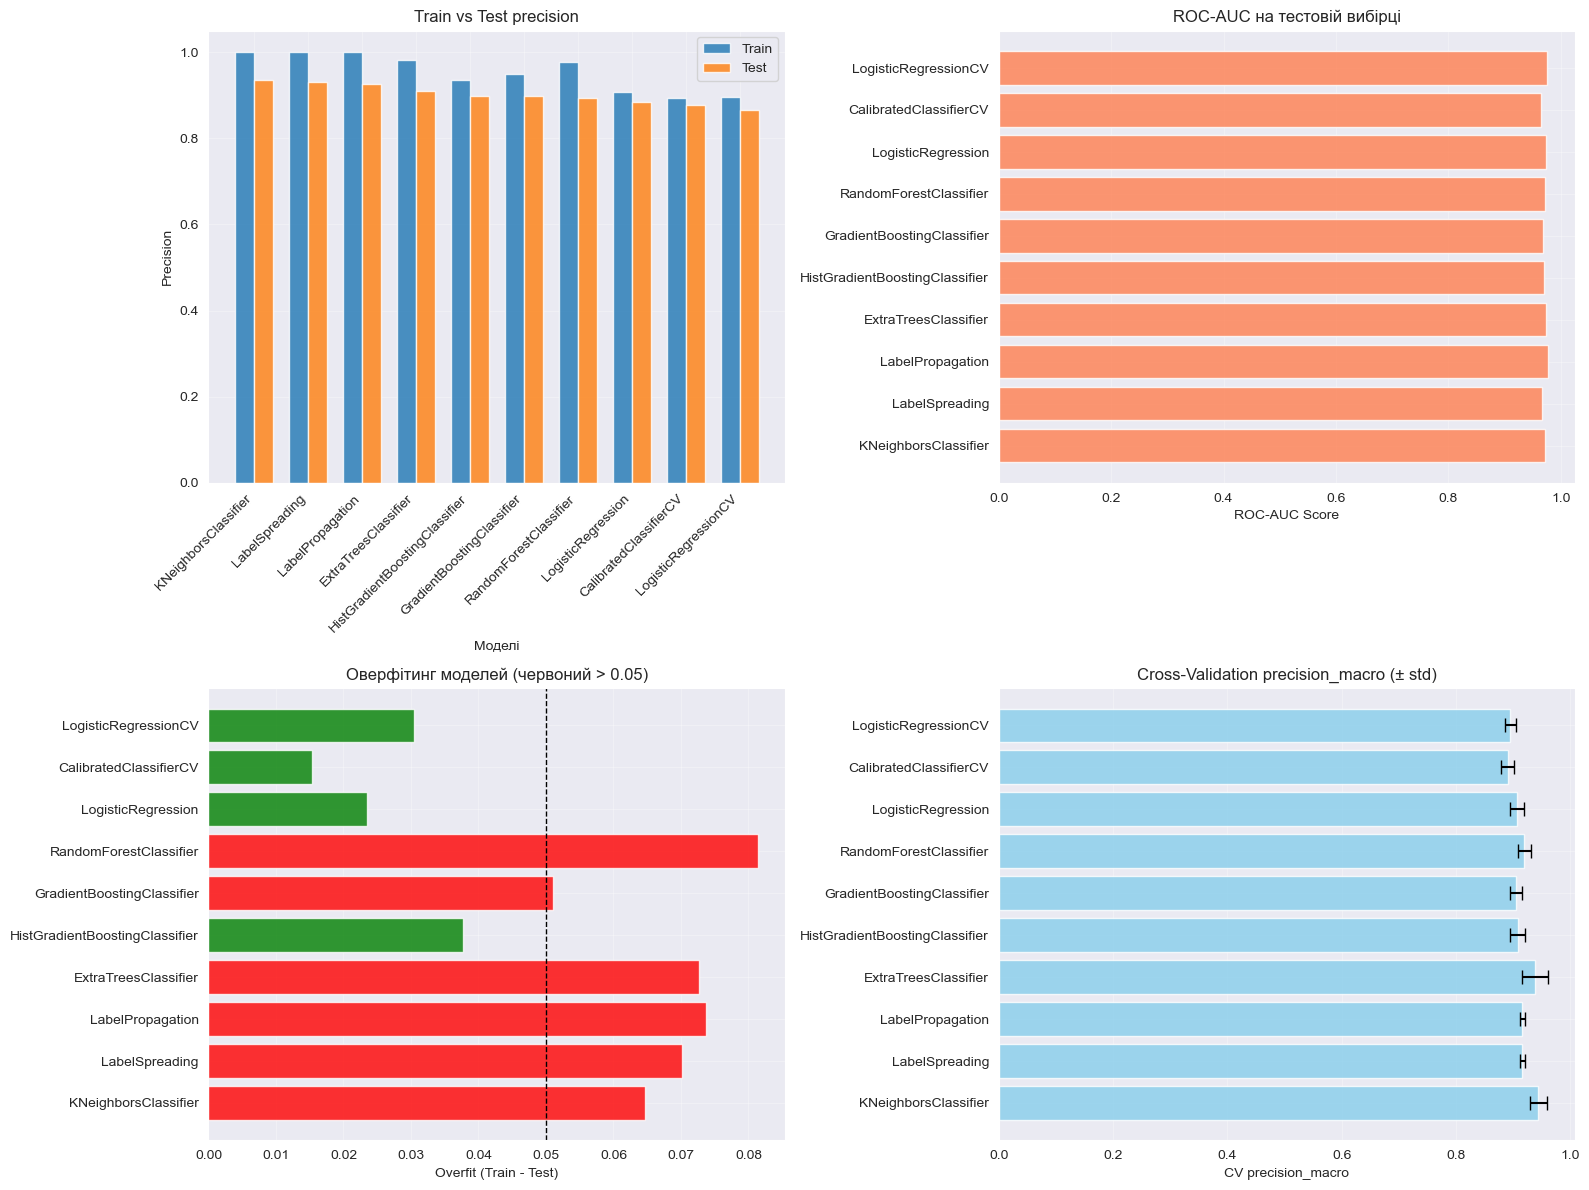


OPTUNA RESULTS


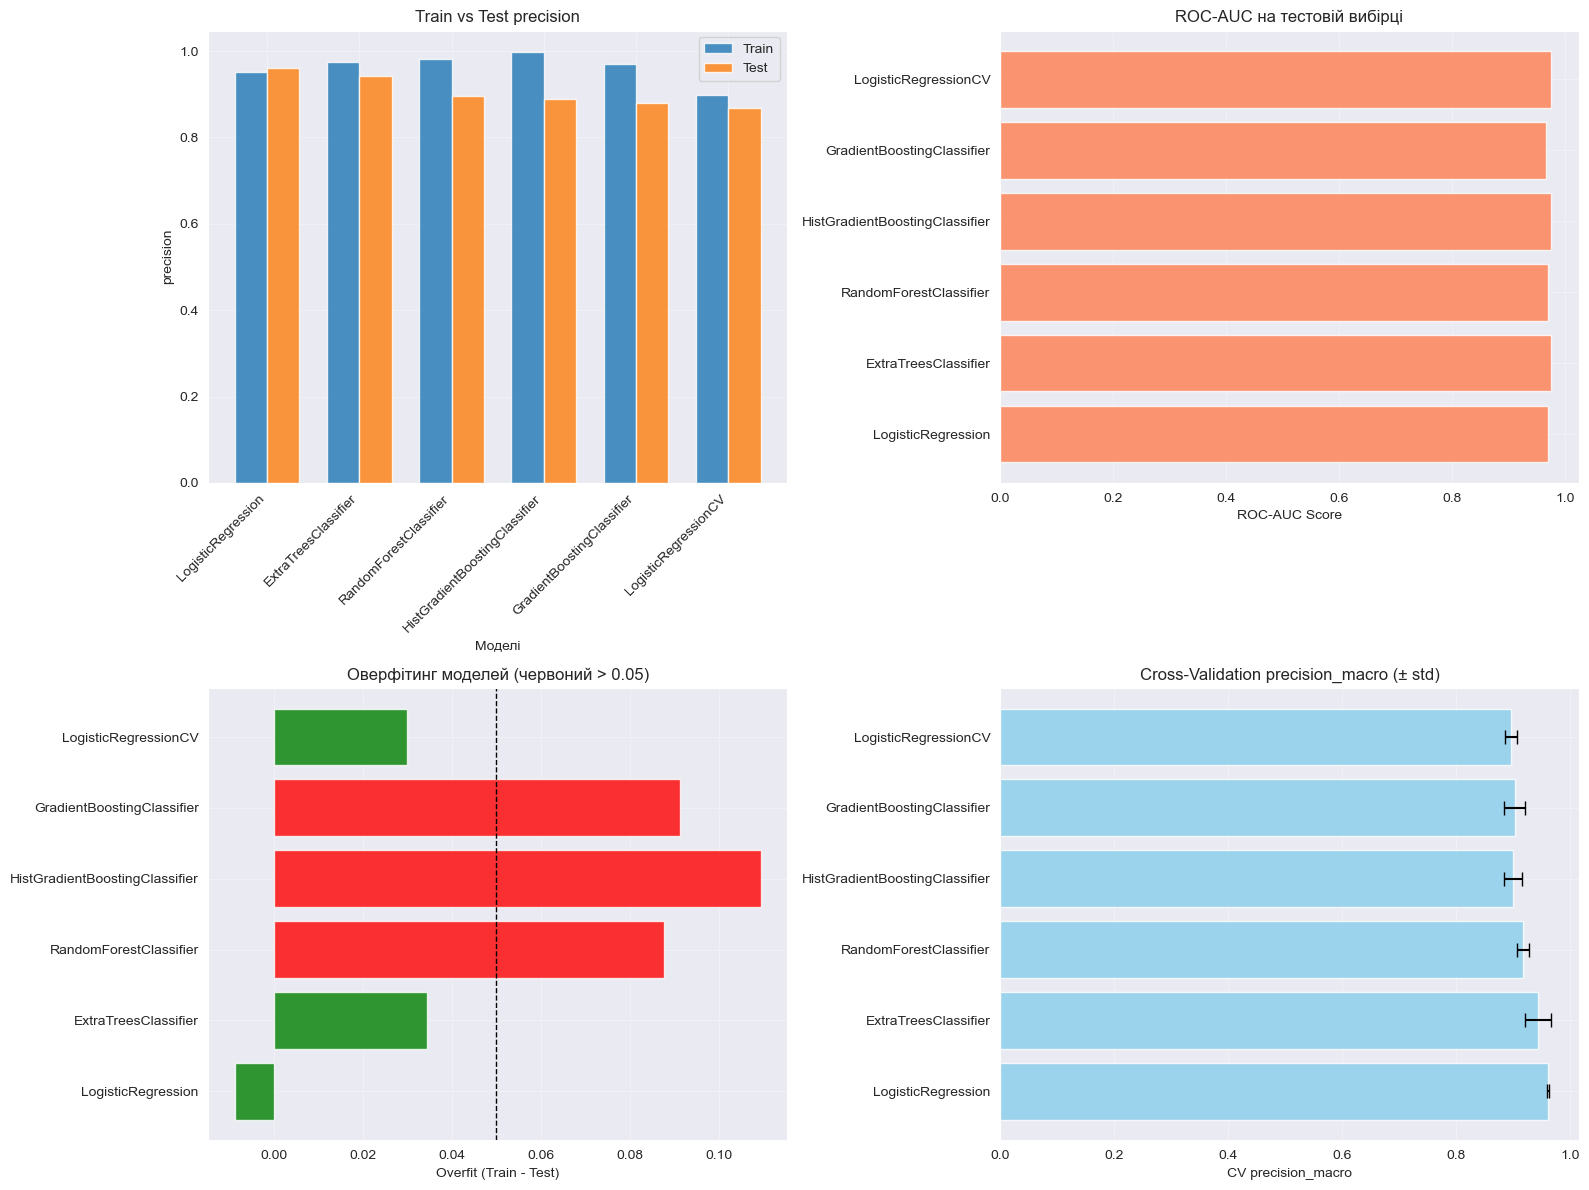


ПІДСУМКОВЕ ПОРІВНЯННЯ МОДЕЛЕЙ
GRIDSEARCH
                         Model  CV precision_macro   CV Std  Train Precision  Test Precision  Train Recall  Test Recall  Train F1  Test F1  ROC-AUC Test  Overfit (Train-Test)
                LabelSpreading            0.916376 0.005034         1.000000        0.929847      1.000000     0.901598  1.000000 0.914522      0.966711              0.070153
              LabelPropagation            0.916376 0.005034         1.000000        0.926241      1.000000     0.901102  1.000000 0.912698      0.976848              0.073759
          LogisticRegressionCV            0.894941 0.009381         0.896621        0.866245      0.863125     0.842255  0.878058 0.853290      0.975734              0.030375
        CalibratedClassifierCV            0.890324 0.011084         0.893244        0.877863      0.835668     0.822490  0.858166 0.844715      0.964676              0.015380
        RandomForestClassifier            0.920022 0.010738         0.975819       

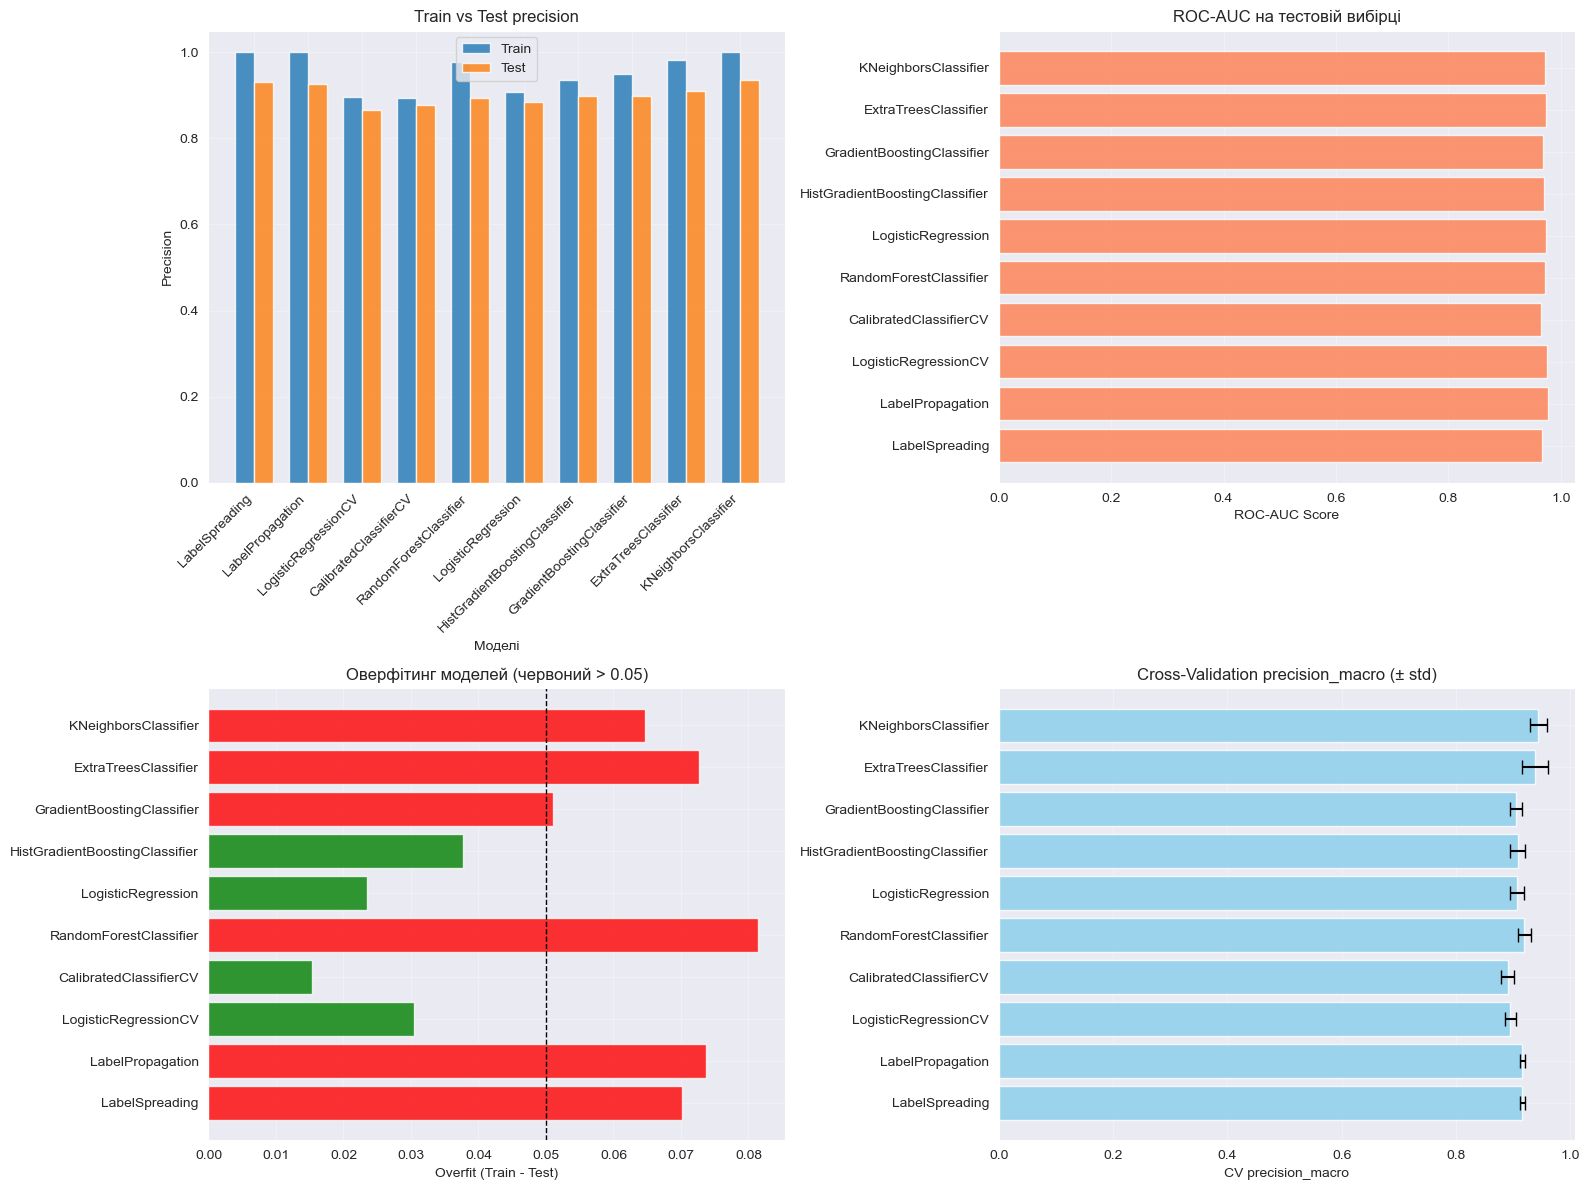


OPTUNA RESULTS


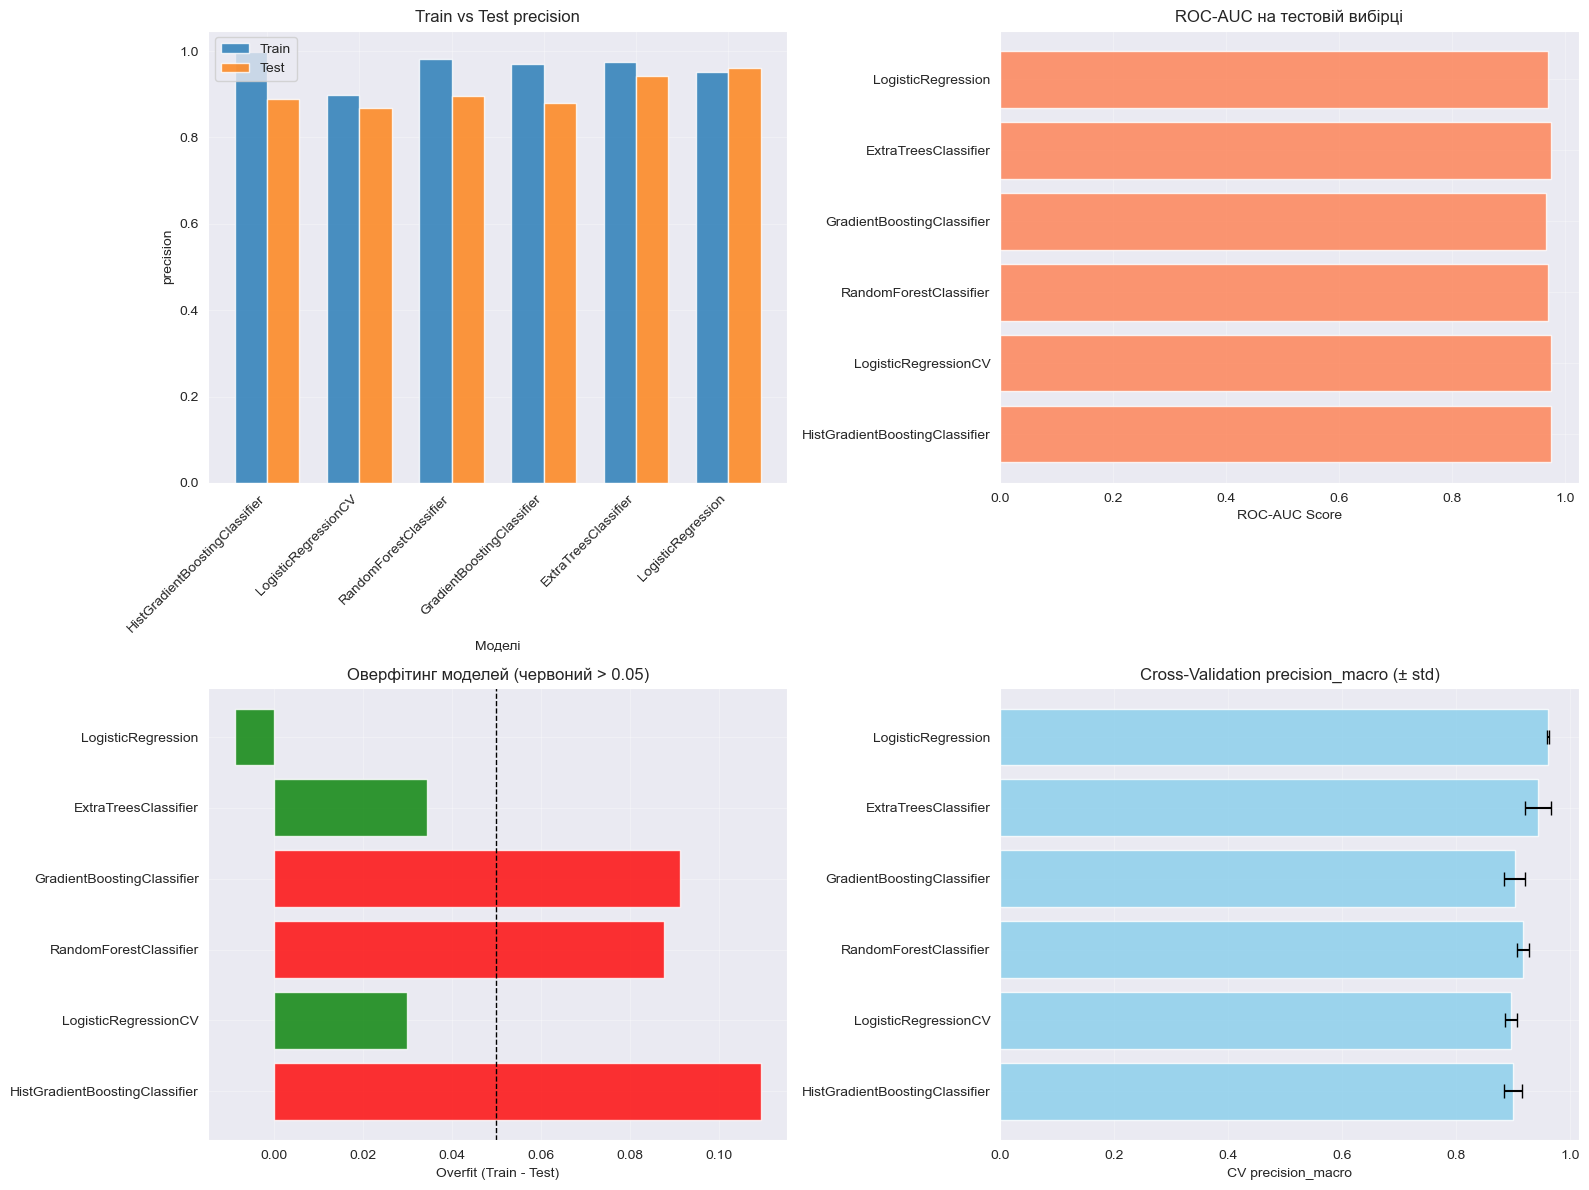

In [29]:
results_comparison = pd.DataFrame({
    'Model': list(tuned_results.keys()),
    'CV precision_macro': [tuned_results[m]['cv_mean_score'] for m in tuned_results],
    'CV Std': [tuned_results[m]['cv_std_score'] for m in tuned_results],
    'Train Precision': [tuned_results[m]['train precision'] for m in tuned_results],
    'Test Precision': [tuned_results[m]['test precision'] for m in tuned_results],
    'Train Recall': [tuned_results[m]['train recall'] for m in tuned_results],
    'Test Recall': [tuned_results[m]['test recall'] for m in tuned_results],
    'Train F1': [tuned_results[m]['train f1'] for m in tuned_results],
    'Test F1': [tuned_results[m]['test f1'] for m in tuned_results],
    'ROC-AUC Test': [tuned_results[m]['roc_auc_test'] for m in tuned_results],
    'Overfit (Train-Test)': [tuned_results[m]['train precision'] - tuned_results[m]['test precision'] 
                              for m in tuned_results]
})

results_comparison_optuna = pd.DataFrame({
    'Model': list(tuned_results_optuna.keys()),
    'CV precision_macro': [tuned_results_optuna[m]['cv_mean_score'] for m in tuned_results_optuna],
    'CV Std': [tuned_results_optuna[m]['cv_std_score'] for m in tuned_results_optuna],
    'Train Precision': [tuned_results_optuna[m]['train precision'] for m in tuned_results_optuna],
    'Test Precision': [tuned_results_optuna[m]['test precision'] for m in tuned_results_optuna],
    'Test Recall': [tuned_results_optuna[m]['test recall'] for m in tuned_results_optuna],
    'Train F1': [tuned_results_optuna[m]['train f1'] for m in tuned_results_optuna],
    'Test F1': [tuned_results_optuna[m]['test f1'] for m in tuned_results_optuna],
    'ROC-AUC Test': [tuned_results_optuna[m]['roc_auc_test'] for m in tuned_results_optuna],
    'Overfit (Train-Test)': [tuned_results_optuna[m]['train precision'] - tuned_results_optuna[m]['test precision'] 
                              for m in tuned_results_optuna]
})

results_comparison_voting = pd.DataFrame({
    'Model': 'VotingClassifier',
    'CV precision_macro': [tuned_results_voting['VotingClassifier']['cv_mean_score']],
    'CV Std': [tuned_results_voting['VotingClassifier']['cv_std_score']],
    'Train Precision': [tuned_results_voting['VotingClassifier']['train precision']],
    'Test Precision': [tuned_results_voting['VotingClassifier']['test precision']],
    'ROC-AUC Test': [tuned_results_voting['VotingClassifier']['roc_auc_test']],
    'Overfit (Train-Test)': [tuned_results_voting['VotingClassifier']['train precision'] - 
                             tuned_results_voting['VotingClassifier']['test precision']]
})

results_comparison_stacking = pd.DataFrame({
    'Model': 'StackingClassifier',
    'CV precision_macro': [tuned_results_stacking['StackingClassifier']['cv_mean_score']],
    'CV Std': [tuned_results_stacking['StackingClassifier']['cv_std_score']],
    'Train Precision': [tuned_results_stacking['StackingClassifier']['train precision']],
    'Test Precision': [tuned_results_stacking['StackingClassifier']['test precision']],
    'Train Recall': [tuned_results_stacking['StackingClassifier']['train recall']],
    'Test Recall': [tuned_results_stacking['StackingClassifier']['test recall']],
    'Train F1': [tuned_results_stacking['StackingClassifier']['train f1']],
    'Test F1': [tuned_results_stacking['StackingClassifier']['test f1']],
    'ROC-AUC Test': [tuned_results_stacking['StackingClassifier']['roc_auc_test']],
    'Overfit (Train-Test)': [tuned_results_stacking['StackingClassifier']['train precision'] - tuned_results_stacking['StackingClassifier']['test precision']]
})

results_comparison = results_comparison.sort_values('Test Precision', ascending=False)
results_comparison_optuna = results_comparison_optuna.sort_values('Test Precision', ascending=False)

print("\n" + "="*80)
print("ПІДСУМКОВЕ ПОРІВНЯННЯ МОДЕЛЕЙ")
print("="*80)
print("GRIDSEARCH")
print(results_comparison.to_string(index=False))
print("\nOPTUNA")
print(results_comparison_optuna.to_string(index=False))
print("\nVOTING CLASSIFIER")
print(results_comparison_voting.to_string(index=False))
print("\nSTACKING CLASSIFIER")
print(results_comparison_stacking.to_string(index=False))

print("\nGRIDSEARCH RESULTS")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax1 = axes[0, 0]
models = results_comparison['Model']
x = np.arange(len(models))
width = 0.35

ax1.bar(x - width/2, results_comparison['Train Precision'], width, label='Train', alpha=0.8)
ax1.bar(x + width/2, results_comparison['Test Precision'], width, label='Test', alpha=0.8)
ax1.set_xlabel('Моделі')
ax1.set_ylabel('Precision')
ax1.set_title('Train vs Test precision')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
ax2.barh(models, results_comparison['ROC-AUC Test'], alpha=0.8, color='coral')
ax2.set_xlabel('ROC-AUC Score')
ax2.set_title('ROC-AUC на тестовій вибірці')
ax2.grid(True, alpha=0.3)

ax3 = axes[1, 0]
colors = ['red' if x > 0.05 else 'green' for x in results_comparison['Overfit (Train-Test)']]
ax3.barh(models, results_comparison['Overfit (Train-Test)'], alpha=0.8, color=colors)
ax3.set_xlabel('Overfit (Train - Test)')
ax3.set_title('Оверфітинг моделей (червоний > 0.05)')
ax3.axvline(x=0.05, color='black', linestyle='--', linewidth=1)
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
ax4.barh(models, results_comparison['CV precision_macro'], 
         xerr=results_comparison['CV Std'], 
         alpha=0.8, color='skyblue', capsize=5)
ax4.set_xlabel('CV precision_macro')
ax4.set_title('Cross-Validation precision_macro (± std)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('grid_search_results.png', dpi=300)
plt.show()

print("\nOPTUNA RESULTS")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax1 = axes[0, 0]
models = results_comparison_optuna['Model']
x = np.arange(len(models))
width = 0.35

ax1.bar(x - width/2, results_comparison_optuna['Train Precision'], width, label='Train', alpha=0.8)
ax1.bar(x + width/2, results_comparison_optuna['Test Precision'], width, label='Test', alpha=0.8)
ax1.set_xlabel('Моделі')
ax1.set_ylabel('precision')
ax1.set_title('Train vs Test precision')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
ax2.barh(models, results_comparison_optuna['ROC-AUC Test'], alpha=0.8, color='coral')
ax2.set_xlabel('ROC-AUC Score')
ax2.set_title('ROC-AUC на тестовій вибірці')
ax2.grid(True, alpha=0.3)

ax3 = axes[1, 0]
colors = ['red' if x > 0.05 else 'green' for x in results_comparison_optuna['Overfit (Train-Test)']]
ax3.barh(models, results_comparison_optuna['Overfit (Train-Test)'], alpha=0.8, color=colors)
ax3.set_xlabel('Overfit (Train - Test)')
ax3.set_title('Оверфітинг моделей (червоний > 0.05)')
ax3.axvline(x=0.05, color='black', linestyle='--', linewidth=1)
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
ax4.barh(models, results_comparison_optuna['CV precision_macro'], 
         xerr=results_comparison_optuna['CV Std'], 
         alpha=0.8, color='skyblue', capsize=5)
ax4.set_xlabel('CV precision_macro')
ax4.set_title('Cross-Validation precision_macro (± std)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('optuna_results.png', dpi=300)
plt.show()
results_comparison = pd.DataFrame({
    'Model': list(tuned_results.keys()),
    'CV precision_macro': [tuned_results[m]['cv_mean_score'] for m in tuned_results],
    'CV Std': [tuned_results[m]['cv_std_score'] for m in tuned_results],
    'Train Precision': [tuned_results[m]['train precision'] for m in tuned_results],
    'Test Precision': [tuned_results[m]['test precision'] for m in tuned_results],
    'Train Recall': [tuned_results[m]['train recall'] for m in tuned_results],
    'Test Recall': [tuned_results[m]['test recall'] for m in tuned_results],
    'Train F1': [tuned_results[m]['train f1'] for m in tuned_results],
    'Test F1': [tuned_results[m]['test f1'] for m in tuned_results],
    'ROC-AUC Test': [tuned_results[m]['roc_auc_test'] for m in tuned_results],
    'Overfit (Train-Test)': [tuned_results[m]['train precision'] - tuned_results[m]['test precision'] 
                              for m in tuned_results]
})

results_comparison_optuna = pd.DataFrame({
    'Model': list(tuned_results_optuna.keys()),
    'CV precision_macro': [tuned_results_optuna[m]['cv_mean_score'] for m in tuned_results_optuna],
    'CV Std': [tuned_results_optuna[m]['cv_std_score'] for m in tuned_results_optuna],
    'Train Precision': [tuned_results_optuna[m]['train precision'] for m in tuned_results_optuna],
    'Test Precision': [tuned_results_optuna[m]['test precision'] for m in tuned_results_optuna],
    'Test Recall': [tuned_results_optuna[m]['test recall'] for m in tuned_results_optuna],
    'Train F1': [tuned_results_optuna[m]['train f1'] for m in tuned_results_optuna],
    'Test F1': [tuned_results_optuna[m]['test f1'] for m in tuned_results_optuna],
    'ROC-AUC Test': [tuned_results_optuna[m]['roc_auc_test'] for m in tuned_results_optuna],
    'Overfit (Train-Test)': [tuned_results_optuna[m]['train precision'] - tuned_results_optuna[m]['test precision'] 
                              for m in tuned_results_optuna]
})

results_comparison_voting = pd.DataFrame({
    'Model': 'VotingClassifier',
    'CV precision_macro': [tuned_results_voting['VotingClassifier']['cv_mean_score']],
    'CV Std': [tuned_results_voting['VotingClassifier']['cv_std_score']],
    'Train Precision': [tuned_results_voting['VotingClassifier']['train precision']],
    'Test Precision': [tuned_results_voting['VotingClassifier']['test precision']],
    'ROC-AUC Test': [tuned_results_voting['VotingClassifier']['roc_auc_test']],
    'Overfit (Train-Test)': [tuned_results_voting['VotingClassifier']['train precision'] - 
                             tuned_results_voting['VotingClassifier']['test precision']]
})

results_comparison_stacking = pd.DataFrame({
    'Model': 'StackingClassifier',
    'CV precision_macro': [tuned_results_stacking['StackingClassifier']['cv_mean_score']],
    'CV Std': [tuned_results_stacking['StackingClassifier']['cv_std_score']],
    'Train Precision': [tuned_results_stacking['StackingClassifier']['train precision']],
    'Test Precision': [tuned_results_stacking['StackingClassifier']['test precision']],
    'Train Recall': [tuned_results_stacking['StackingClassifier']['train recall']],
    'Test Recall': [tuned_results_stacking['StackingClassifier']['test recall']],
    'Train F1': [tuned_results_stacking['StackingClassifier']['train f1']],
    'Test F1': [tuned_results_stacking['StackingClassifier']['test f1']],
    'ROC-AUC Test': [tuned_results_stacking['StackingClassifier']['roc_auc_test']],
    'Overfit (Train-Test)': [tuned_results_stacking['StackingClassifier']['train precision'] - tuned_results_stacking['StackingClassifier']['test precision']]
})

results_comparison = results_comparison.sort_values('Test F1', ascending=False)
results_comparison_optuna = results_comparison_optuna.sort_values('Test F1', ascending=False)

print("\n" + "="*80)
print("ПІДСУМКОВЕ ПОРІВНЯННЯ МОДЕЛЕЙ")
print("="*80)
print("GRIDSEARCH")
print(results_comparison.to_string(index=False))
print("\nOPTUNA")
print(results_comparison_optuna.to_string(index=False))
print("\nVOTING CLASSIFIER")
print(results_comparison_voting.to_string(index=False))
print("\nSTACKING CLASSIFIER")
print(results_comparison_stacking.to_string(index=False))

print("\nGRIDSEARCH RESULTS")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax1 = axes[0, 0]
models = results_comparison['Model']
x = np.arange(len(models))
width = 0.35

ax1.bar(x - width/2, results_comparison['Train Precision'], width, label='Train', alpha=0.8)
ax1.bar(x + width/2, results_comparison['Test Precision'], width, label='Test', alpha=0.8)
ax1.set_xlabel('Моделі')
ax1.set_ylabel('Precision')
ax1.set_title('Train vs Test precision')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
ax2.barh(models, results_comparison['ROC-AUC Test'], alpha=0.8, color='coral')
ax2.set_xlabel('ROC-AUC Score')
ax2.set_title('ROC-AUC на тестовій вибірці')
ax2.grid(True, alpha=0.3)

ax3 = axes[1, 0]
colors = ['red' if x > 0.05 else 'green' for x in results_comparison['Overfit (Train-Test)']]
ax3.barh(models, results_comparison['Overfit (Train-Test)'], alpha=0.8, color=colors)
ax3.set_xlabel('Overfit (Train - Test)')
ax3.set_title('Оверфітинг моделей (червоний > 0.05)')
ax3.axvline(x=0.05, color='black', linestyle='--', linewidth=1)
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
ax4.barh(models, results_comparison['CV precision_macro'], 
         xerr=results_comparison['CV Std'], 
         alpha=0.8, color='skyblue', capsize=5)
ax4.set_xlabel('CV precision_macro')
ax4.set_title('Cross-Validation precision_macro (± std)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/classification/default/graphics/grid_search_results.png', dpi=300)
plt.show()

print("\nOPTUNA RESULTS")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax1 = axes[0, 0]
models = results_comparison_optuna['Model']
x = np.arange(len(models))
width = 0.35

ax1.bar(x - width/2, results_comparison_optuna['Train Precision'], width, label='Train', alpha=0.8)
ax1.bar(x + width/2, results_comparison_optuna['Test Precision'], width, label='Test', alpha=0.8)
ax1.set_xlabel('Моделі')
ax1.set_ylabel('precision')
ax1.set_title('Train vs Test precision')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
ax2.barh(models, results_comparison_optuna['ROC-AUC Test'], alpha=0.8, color='coral')
ax2.set_xlabel('ROC-AUC Score')
ax2.set_title('ROC-AUC на тестовій вибірці')
ax2.grid(True, alpha=0.3)

ax3 = axes[1, 0]
colors = ['red' if x > 0.05 else 'green' for x in results_comparison_optuna['Overfit (Train-Test)']]
ax3.barh(models, results_comparison_optuna['Overfit (Train-Test)'], alpha=0.8, color=colors)
ax3.set_xlabel('Overfit (Train - Test)')
ax3.set_title('Оверфітинг моделей (червоний > 0.05)')
ax3.axvline(x=0.05, color='black', linestyle='--', linewidth=1)
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
ax4.barh(models, results_comparison_optuna['CV precision_macro'], 
         xerr=results_comparison_optuna['CV Std'], 
         alpha=0.8, color='skyblue', capsize=5)
ax4.set_xlabel('CV precision_macro')
ax4.set_title('Cross-Validation precision_macro (± std)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/classification/enn/graphics/optuna_results.png', dpi=300)
plt.show()

In [32]:
final_combined_results = pd.concat([
        results_comparison,
        results_comparison_voting,
        results_comparison_stacking
    ], ignore_index=True)
final_combined_results = final_combined_results.sort_values('Test F1', ascending=False).round(4).reset_index(drop=True)

print("\n" + "="*80)
print("ОБ'ЄДНАНІ РЕЗУЛЬТАТИ: Індивідуальні Optuna та Ансамблеві моделі")
print("="*80)
print(final_combined_results.to_string(index=False))


ОБ'ЄДНАНІ РЕЗУЛЬТАТИ: Індивідуальні Optuna та Ансамблеві моделі
                         Model  CV precision_macro  CV Std  Train Precision  Test Precision  Train Recall  Test Recall  Train F1  Test F1  ROC-AUC Test  Overfit (Train-Test)
            StackingClassifier              0.9577  0.0079           1.0000          0.9363        1.0000       0.8990    1.0000   0.9159        0.9807                0.0637
                LabelSpreading              0.9164  0.0050           1.0000          0.9298        1.0000       0.9016    1.0000   0.9145        0.9667                0.0702
              LabelPropagation              0.9164  0.0050           1.0000          0.9262        1.0000       0.9011    1.0000   0.9127        0.9768                0.0738
          LogisticRegressionCV              0.8949  0.0094           0.8966          0.8662        0.8631       0.8423    0.8781   0.8533        0.9757                0.0304
        CalibratedClassifierCV              0.8903  0.0111       

Побудова ROC-кривих для Top-10 моделей...
  StackingClassifier: Побудовано (AUC = 0.990)
  LabelSpreading: Побудовано (AUC = 0.990)
  LabelPropagation: Побудовано (AUC = 0.992)
  LogisticRegressionCV: Побудовано (AUC = 0.994)
  CalibratedClassifierCV: Побудовано (AUC = 0.991)
  RandomForestClassifier: Побудовано (AUC = 0.993)
  LogisticRegression: Побудовано (AUC = 0.992)
  HistGradientBoostingClassifier: Побудовано (AUC = 0.991)
  GradientBoostingClassifier: Побудовано (AUC = 0.988)
  ExtraTreesClassifier: Побудовано (AUC = 0.992)


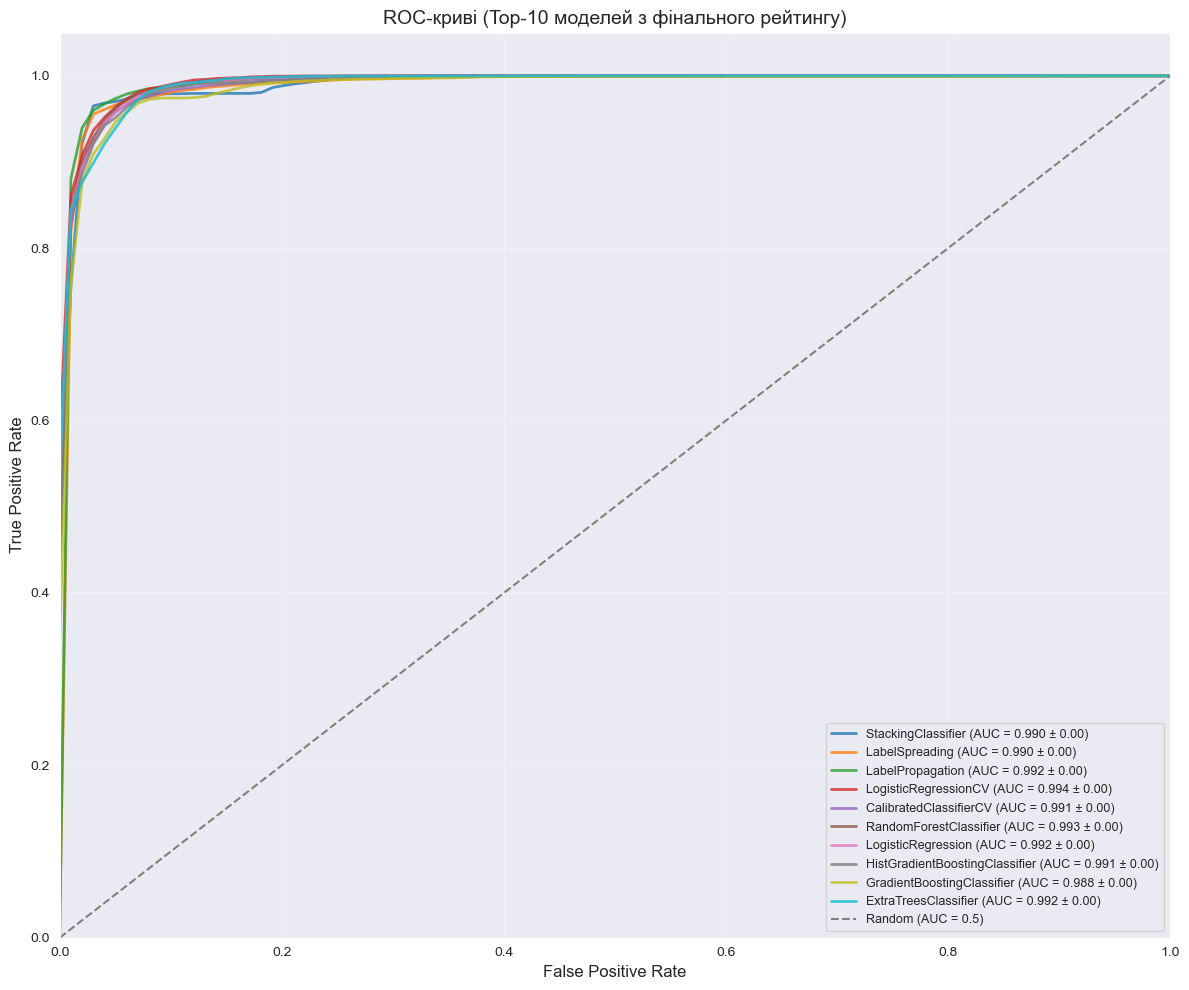

ROC-криві побудовано на основі фінального порівняння!


In [52]:
# 1. Створюємо єдиний словник усіх об'єктів моделей для швидкого пошуку за назвою
all_tuned_models = {**tuned_results_optuna, **tuned_results_voting, **tuned_results_stacking,**tuned_results}

plt.figure(figsize=(12, 10))
mean_fpr = np.linspace(0, 1, 100)

# Беремо топ-10 моделей з вашої відсортованої таблиці
top_10_df = final_combined_results.head(10)

print(f"Побудова ROC-кривих для Top-{len(top_10_df)} моделей...")
print("="*80)

# Ітеруємося по рядках DataFrame
for idx, row in top_10_df.iterrows():
    model_name = row['Model']
    try:
        # Отримуємо об'єкт моделі зі словника за назвою з таблиці
        if model_name in all_tuned_models:
            best_model = all_tuned_models[model_name]['model']
        else:
            print(f"  [SKIP] Модель {model_name} не знайдена в словниках об'єктів.")
            continue

        tprs, aucs = [], []

        # Крос-валідація для побудови середньої ROC-кривої
        for train_idx, val_idx in CV.split(X_train, y_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]

            model_fold = clone(best_model)
            model_fold.fit(X_tr, y_tr)

            # Отримуємо оцінки ймовірності
            if hasattr(model_fold, 'predict_proba'):
                y_scores = model_fold.predict_proba(X_val)
            elif hasattr(model_fold, 'decision_function'):
                y_scores = model_fold.decision_function(X_val)
                if y_scores.ndim == 1:
                    y_scores = np.vstack([1 - y_scores, y_scores]).T
            else:
                continue

            # Обробка багатокласовості або бінарної класифікації
            if is_multiclass:
                y_val_bin = label_binarize(y_val, classes=np.arange(n_classes))
                # Використовуємо micro-average (ravel) для стабільності
                fpr, tpr, _ = roc_curve(y_val_bin.ravel(), y_scores.ravel())
                aucs.append(auc(fpr, tpr))
                tprs.append(np.interp(mean_fpr, fpr, tpr))
            else:
                prob_pos = y_scores[:, 1] if y_scores.ndim == 2 else y_scores
                fpr, tpr, _ = roc_curve(y_val, prob_pos)
                aucs.append(auc(fpr, tpr))
                tprs.append(np.interp(mean_fpr, fpr, tpr))

        if not tprs:
            continue

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)

        # Використовуємо назву з таблиці та AUC з розрахунку
        plt.plot(mean_fpr, mean_tpr,
                label=f"{model_name} (AUC = {mean_auc:.3f} ± {std_auc:.2f})",
                linewidth=2, alpha=0.8)
        print(f"  {model_name}: Побудовано (AUC = {mean_auc:.3f})")

    except Exception as e:
        print(f"  {model_name}: Помилка - {e}")
        continue

# Оформлення графіка
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random (AUC = 0.5)', linewidth=1.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC-криві (Top-10 моделей з фінального рейтингу)', fontsize=14)
plt.legend(loc='lower right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('results/classification/enn/graphics/roc_curves_final.png', dpi=300)
plt.show()

print("="*80)
print("ROC-криві побудовано на основі фінального порівняння!")

In [33]:
best_model_name = final_combined_results.iloc[0]['Model']
best_model_name

'StackingClassifier'

In [34]:
if best_model_name == 'StackingClassifier':
    best_model_obj = tuned_results_stacking[best_model_name]['model']
elif best_model_name == 'VotingClassifier':
    best_model_obj = tuned_results_voting[best_model_name]['model']
else:
    best_model_obj = tuned_results_optuna[best_model_name]['model']

In [35]:
joblib.dump(best_model_obj, 'results/classification/enn/model/enn.pkl')

['results/classification/enn/model/enn.pkl']

Файл моделі не знайдено. Перевірте шлях!
ДЕТАЛЬНИЙ АНАЛІЗ НАЙКРАЩОЇ МОДЕЛІ: StackingClassifier

Classification Report на тренувальній вибірці:
----------------------------------------
              precision    recall  f1-score   support

        High       1.00      1.00      1.00       800
         Low       1.00      1.00      1.00      5375
      Medium       1.00      1.00      1.00       694

    accuracy                           1.00      6869
   macro avg       1.00      1.00      1.00      6869
weighted avg       1.00      1.00      1.00      6869


Classification Report на тестовій вибірці:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

        High       1.00      0.99      1.00       200
         Low       0.96      0.98      0.97      1344
      Medium       0.84      0.72      0.78       174

    accuracy                           0.96      1718
   macro avg       0.94      0.90     

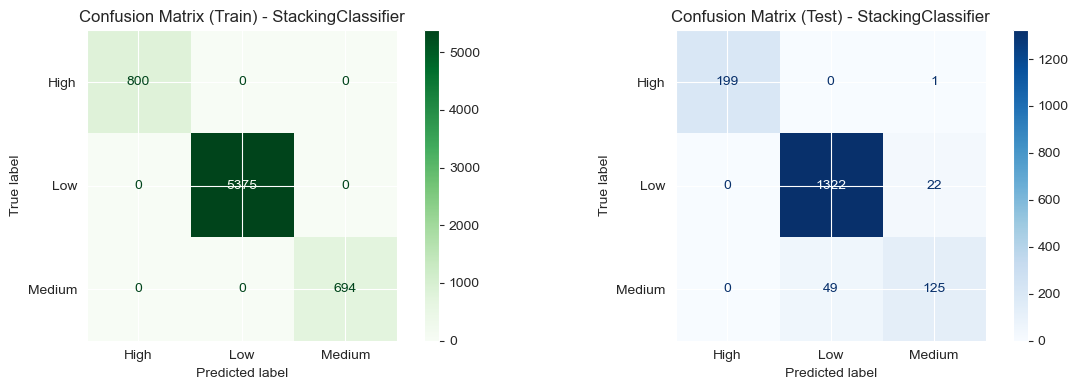


ВАЖЛИВІСТЬ ОЗНАК ДЛЯ StackingClassifier


In [36]:

model_path = 'results/classification/enn/model/best_classification_default_model.pkl'

if os.path.exists(model_path):
    best_model_obj = joblib.load(model_path)
    print(f"Модель успішно завантажена з {model_path}")

    if hasattr(best_model_obj, "predict"):
        print("Модель готова до використання.")
else:
    print("Файл моделі не знайдено. Перевірте шлях!")

print("="*80)
print(f"ДЕТАЛЬНИЙ АНАЛІЗ НАЙКРАЩОЇ МОДЕЛІ: {best_model_name}")
print("="*80)

y_train_pred = best_model_obj.predict(X_train)
y_test_pred = best_model_obj.predict(X_test)

print("\nClassification Report на тренувальній вибірці:")
print("-" * 40)
print(classification_report(y_train, y_train_pred, target_names=le_y.classes_))

print("\nClassification Report на тестовій вибірці:")
print("-"*80)
print(classification_report(y_test, y_test_pred, target_names=le_y.classes_))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=le_y.classes_)
disp_train.plot(ax=ax1, cmap='Greens', values_format='d')
ax1.set_title(f'Confusion Matrix (Train) - {best_model_name}')

cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=le_y.classes_)
disp_test.plot(ax=ax2, cmap='Blues', values_format='d')
ax2.set_title(f'Confusion Matrix (Test) - {best_model_name}')

plt.tight_layout()
plt.savefig('results/classification/enn/graphics/confusion_matrix.png', dpi=1000)
plt.show()

print("\n" + "="*80)
print(f"ВАЖЛИВІСТЬ ОЗНАК ДЛЯ {best_model_name}")
print("="*80)

if best_model_name in feature_importance_dict:
    importances = feature_importance_dict[best_model_name]
    feature_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print(feature_imp_df.to_string(index=False))
    
    top_n = min(20, len(feature_imp_df))
    plt.figure(figsize=(10, 8))
    plt.barh(range(top_n), feature_imp_df['Importance'].head(top_n), alpha=0.8)
    plt.yticks(range(top_n), feature_imp_df['Feature'].head(top_n))
    plt.xlabel('Важливість')
    plt.title(f'Top-{top_n} найважливіших ознак - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('results/classification/enn/graphics/feature_importance.png', dpi=300)
    plt.show()


АНАЛІЗ ПОМИЛКОВИХ ПЕРЕДБАЧЕНЬ (TEST)

Кількість помилок: 72 з 1718 (4.19%)

ПЕРШІ 10 РЯДКІВ ІЗ ПОМИЛКОВИМИ ЗНАЧЕННЯМИ (ОРИГІНАЛЬНІ ДАНІ):
--------------------------------------------------------------------------------


,True_Class,Predicted_Class,Confidence,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),...,Family History of Anxiety,Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10)
3018,Medium,Low,0.645882,46.0,Male,Other,6.9,1.9,281.0,0.0,...,No,9.0,75.0,13.0,1.0,No,Yes,1.0,Yes,4.0
9677,Low,Medium,0.474160,52.0,Female,Teacher,7.9,1.0,50.0,1.0,...,No,5.0,82.0,14.0,1.0,No,No,3.0,No,8.0
1471,Medium,Low,0.602287,59.0,Other,Artist,6.1,2.7,142.0,10.0,...,Yes,10.0,79.0,19.0,3.0,No,Yes,2.0,Yes,10.0
8664,Medium,Low,0.717060,40.0,Other,Scientist,8.1,4.5,404.0,5.0,...,No,8.0,63.0,29.0,1.0,Yes,Yes,1.0,Yes,2.0
2143,Medium,Low,0.723047,31.0,Female,Athlete,7.6,1.2,214.0,0.0,...,No,9.0,111.0,25.0,5.0,Yes,No,1.0,No,7.0
6416,Medium,Low,0.549970,52.0,Other,Lawyer,6.9,4.0,577.0,16.0,...,No,10.0,61.0,15.0,5.0,Yes,No,1.0,Yes,6.0
6971,Medium,Low,0.753444,33.0,Female,Freelancer,8.0,2.8,335.0,0.0,...,Yes,6.0,105.0,23.0,4.0,Yes,No,2.0,Yes,3.0
6514,Medium,Low,0.703794,38.0,Male,Student,7.6,0.8,297.0,8.0,...,Yes,8.0,73.0,27.0,2.0,No,No,2.0,Yes,2.0
3345,Low,Medium,0.514471,49.0,Male,Lawyer,5.1,4.4,396.0,0.0,...,No,10.0,83.0,27.0,3.0,No,Yes,2.0,No,8.0
8842,Medium,Low,0.737533,35.0,Male,Scientist,8.2,2.3,580.0,4.0,...,Yes,7.0,100.0,23.0,4.0,Yes,Yes,2.0,No,6.0


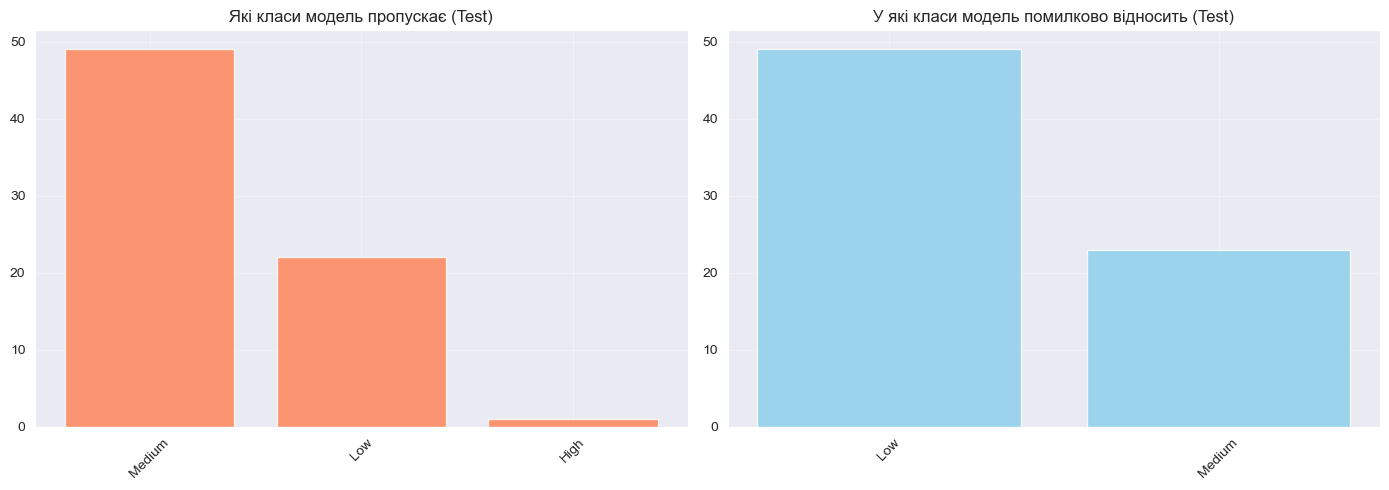

In [37]:
def perform_error_analysis(X, y_true, y_pred, model, le_target,
                           label_encoders=None, scaler=None,
                           numeric_cols=None, categorical_cols=None,
                           dataset_name="Test", filename="plot.png"):
    """
    Аналіз помилок із дестандартизацією числових даних та декодуванням категорійних ознак.
    """
    print("\n" + "="*80)
    print(f"АНАЛІЗ ПОМИЛКОВИХ ПЕРЕДБАЧЕНЬ ({dataset_name.upper()})")
    print("="*80)

    y_true_arr = np.asarray(y_true)
    y_pred_arr = np.asarray(y_pred)

    wrong_indices = np.where(y_true_arr != y_pred_arr)[0]
    num_errors = len(wrong_indices)

    if num_errors > 0:
        # 1. Копіюємо дані ознак для помилкових випадків
        X_errors = X.iloc[wrong_indices].copy()

        # --- ЗВОРОТНЕ ПЕРЕТВОРЕННЯ (ДЛЯ ВІДОБРАЖЕННЯ) ---

        # Дестандартизація числових значень
        if scaler is not None and numeric_cols is not None:
            # Створюємо тимчасовий DF, щоб зберегти назви колонок при інверсії
            X_errors[numeric_cols] = scaler.inverse_transform(X_errors[numeric_cols])

        # Декодування категорійних значень
        if label_encoders is not None and categorical_cols is not None:
            for col in categorical_cols:
                if col in label_encoders and col in X_errors.columns:
                    # Оскільки при навчанні ми могли перетворити в int, повертаємо назви класів
                    X_errors[col] = label_encoders[col].inverse_transform(X_errors[col].astype(int))

        # 2. Створюємо DataFrame з результатами класифікації (використовуємо індекс X_errors)
        errors_df = pd.DataFrame({
            'True_Class': le_target.inverse_transform(y_true_arr[wrong_indices]),
            'Predicted_Class': le_target.inverse_transform(y_pred_arr[wrong_indices])
        }, index=X_errors.index)

        if hasattr(model, 'predict_proba'):
            proba = model.predict_proba(X.iloc[wrong_indices]) # Використовуємо ОРИГІНАЛЬНІ (масштабовані) дані для передбачення ймовірності
            errors_df['Confidence'] = proba.max(axis=1)

        # 3. Об'єднуємо декодовані дані
        full_errors_df = pd.concat([errors_df, X_errors], axis=1)

        print(f"\nКількість помилок: {num_errors} з {len(y_true)} ({num_errors/len(y_true)*100:.2f}%)")
        print(f"\nПЕРШІ 10 РЯДКІВ ІЗ ПОМИЛКОВИМИ ЗНАЧЕННЯМИ (ОРИГІНАЛЬНІ ДАНІ):")
        print("-" * 80)
        display(full_errors_df.head(10))

        # Візуалізація
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        ax1 = axes[0]
        true_class_errors = full_errors_df['True_Class'].value_counts()
        ax1.bar(true_class_errors.index, true_class_errors.values, alpha=0.8, color='coral')
        ax1.set_title(f'Які класи модель пропускає ({dataset_name})')
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(True, alpha=0.3)

        ax2 = axes[1]
        pred_class_errors = full_errors_df['Predicted_Class'].value_counts()
        ax2.bar(pred_class_errors.index, pred_class_errors.values, alpha=0.8, color='skyblue')
        ax2.set_title(f'У які класи модель помилково відносить ({dataset_name})')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print(f"Помилок у наборі {dataset_name} не виявлено!")

    return full_errors_df

# ПРИКЛАД ВИКЛИКУ (використовуйте ваші змінні зі скрипта):
error_df = perform_error_analysis(
    X_test, y_test, y_test_pred,
    best_model_obj,
    le_target=le_y,             # LabelEncoder для цільової змінної
    label_encoders=label_encoders, # Словник енкодерів для колонок
    scaler=scaler,               # Ваш StandardScaler
    numeric_cols=numeric_cols,   # Список числових колонок
    categorical_cols=categorical_cols, # Список категорійних колонок
    dataset_name="Test",
    filename="results/classification/enn/graphics/errors_test_analysis.png"
)


ГЛИБОКИЙ АНАЛІЗ ПРИЧИН ПОМИЛОК (TRAIN)
Немає помилок для аналізу в наборі Train.

ГЛИБОКИЙ АНАЛІЗ ПРИЧИН ПОМИЛОК (TEST)


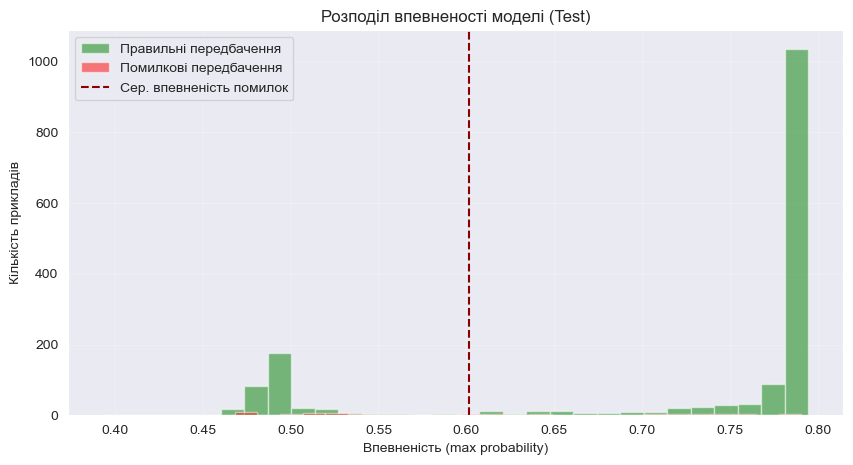


Топ ознак, що найбільше відрізняються в помилкових прогнозах (Test):
Це вказує на те, які фактори найчастіше корелюють із помилкою.
--------------------------------------------------------------------------------


,Mean_in_Errors,Mean_Overall,Difference_%
Caffeine Intake (mg/day),0.199070,-0.001425,-14065.441409
Sleep Hours,0.292501,0.006740,4239.793974
Physical Activity (hrs/week),0.072693,-0.002067,-3616.952992
Alcohol Consumption (drinks/week),-0.162381,-0.005976,2617.265405
Sweating Level (1-5),0.121077,-0.009793,-1336.405844
Diet Quality (1-10),0.191458,-0.035660,-636.905593
Heart Rate (bpm),-0.235653,0.048928,-581.629016
Breathing Rate (breaths/min),-0.155967,0.033948,-559.428796
Stress Level (1-10),0.765564,-0.196518,-489.563609
Age,0.017415,-0.015009,-216.028400


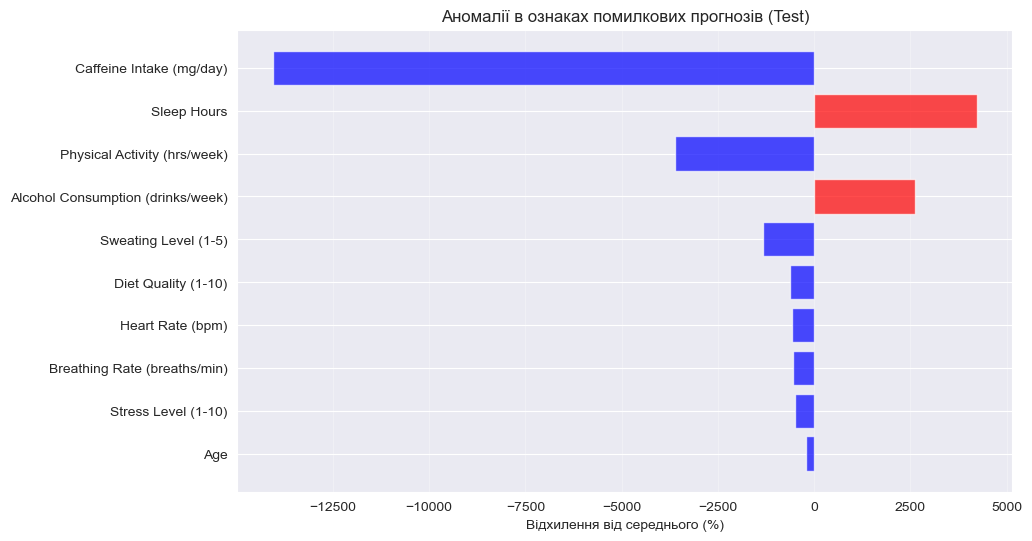

In [38]:
def deep_error_reason_analysis(X, y_true, y_pred, model, dataset_name="Test"):
    print("\n" + "="*80)
    print(f"ГЛИБОКИЙ АНАЛІЗ ПРИЧИН ПОМИЛОК ({dataset_name.upper()})")
    print("="*80)

    wrong_idx = np.where(y_true != y_pred)[0]
    correct_idx = np.where(y_true == y_pred)[0]
    
    if len(wrong_idx) == 0:
        print(f"Немає помилок для аналізу в наборі {dataset_name}.")
        return

    if hasattr(model, 'predict_proba'):
        all_probs = model.predict_proba(X)
        confidences = all_probs.max(axis=1)
        
        plt.figure(figsize=(10, 5))
        plt.hist(confidences[correct_idx], bins=30, alpha=0.5, label='Правильні передбачення', color='green')
        plt.hist(confidences[wrong_idx], bins=30, alpha=0.5, label='Помилкові передбачення', color='red')
        plt.axvline(confidences[wrong_idx].mean(), color='darkred', linestyle='--', label='Сер. впевненість помилок')
        plt.title(f'Розподіл впевненості моделі ({dataset_name})')
        plt.xlabel('Впевненість (max probability)')
        plt.ylabel('Кількість прикладів')
        plt.legend()
        plt.grid(True, alpha=0.2)
        plt.savefig(f'results/classification/default/graphics/confidence_distribution_{dataset_name}.png', dpi=300)
        plt.show()

    mean_errors = X.iloc[wrong_idx].mean()
    mean_total = X.mean()
    
    feature_diff = ((mean_errors - mean_total) / (mean_total + 1e-9)) * 100
    
    diff_df = pd.DataFrame({
        'Mean_in_Errors': mean_errors,
        'Mean_Overall': mean_total,
        'Difference_%': feature_diff
    }).sort_values(by='Difference_%', key=abs, ascending=False)

    print(f"\nТоп ознак, що найбільше відрізняються в помилкових прогнозах ({dataset_name}):")
    print("Це вказує на те, які фактори найчастіше корелюють із помилкою.")
    print("-" * 80)
    display(diff_df.head(15))

    plt.figure(figsize=(10, 6))
    top_diffs = diff_df.head(10)
    colors = ['red' if x > 0 else 'blue' for x in top_diffs['Difference_%']]
    plt.barh(top_diffs.index, top_diffs['Difference_%'], color=colors, alpha=0.7)
    plt.xlabel('Відхилення від середнього (%)')
    plt.title(f'Аномалії в ознаках помилкових прогнозів ({dataset_name})')
    plt.grid(axis='x', alpha=0.3)
    plt.gca().invert_yaxis()
    plt.savefig(f'results/classification/enn/graphics/feature_anomaly{dataset_name}.png', dpi=300)
    plt.show()

deep_error_reason_analysis(X_train, y_train, y_train_pred, best_model_obj, dataset_name="Train")
deep_error_reason_analysis(X_test, y_test, y_test_pred, best_model_obj, dataset_name="Test")

In [46]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, Dict, List, Union

def perform_shap_analysis(
    model,
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_test: Optional[pd.Series] = None,
    feature_names: Optional[List[str]] = None,
    label_encoders: Optional[Dict] = None,
    scaler: Optional[object] = None,
    numeric_cols: Optional[List[str]] = None,
    categorical_cols: Optional[List[str]] = None,
    class_to_analyze: int = 0,
    target_column: str = "AnxietyClass",
    class_names: Optional[List[str]] = None,
    max_display: int = 20,
    sample_size: int = 100,
    max_test_samples: int = 500,
    use_kernel_explainer: bool = False,
    num_samples_to_explain: int = 3,
    save_plots: bool = True,
    output_dir: str = "shap_plots"
):
    """
    Виконує SHAP аналіз для інтерпретації моделі машинного навчання.
    Оптимізовано для найновішої версії SHAP (0.43+).
    
    Параметри:
    ----------
    model : trained model object
        Навчена модель (підтримує TreeExplainer або KernelExplainer)
    X_train : pd.DataFrame
        Тренувальні дані
    X_test : pd.DataFrame
        Тестові дані для аналізу
    y_test : pd.Series, optional
        Цільова змінна для тестових даних (для отримання назв класів)
    feature_names : List[str], optional
        Назви ознак для відображення
    label_encoders : Dict, optional
        Словник label encoders для декодування категоріальних ознак
    scaler : object, optional
        Об'єкт scaler для зворотного перетворення числових ознак
    numeric_cols : List[str], optional
        Список числових колонок
    categorical_cols : List[str], optional
        Список категоріальних колонок
    class_to_analyze : int, default=0
        Індекс класу для аналізу (для багатокласової класифікації)
    target_column : str, default="AnxietyClass"
        Назва колонки з цільовою змінною
    class_names : List[str], optional
        Список назв класів (якщо не вказано, буде витягнуто з y_test)
    max_display : int, default=20
        Максимальна кількість ознак для відображення
    sample_size : int, default=100
        Розмір вибірки для KernelExplainer
    max_test_samples : int, default=500
        Максимальна кількість тестових зразків для аналізу (економія пам'яті)
    use_kernel_explainer : bool, default=False
        Примусове використання KernelExplainer
    num_samples_to_explain : int, default=3
        Кількість зразків для детального пояснення (waterfall/force plots)
    save_plots : bool, default=True
        Чи зберігати графіки у файли
    output_dir : str, default="shap_plots"
        Директорія для збереження графіків
    """
    
    import os
    from datetime import datetime
    
    # Отримуємо назви класів
    if class_names is None and y_test is not None:
        if label_encoders is not None and target_column in label_encoders:
            # Отримуємо унікальні класи з декодованих значень
            class_names = list(label_encoders[target_column].classes_)
            print(f"[INFO] Знайдено класи з encoder: {class_names}")
        else:
            # Якщо немає encoder, беремо унікальні значення
            # Перевіряємо чи y_test це pandas Series чи numpy array
            if isinstance(y_test, pd.Series):
                class_names = sorted(y_test.unique().tolist())
            elif isinstance(y_test, np.ndarray):
                class_names = sorted(np.unique(y_test).tolist())
            else:
                class_names = sorted(list(set(y_test)))
            print(f"[INFO] Класи з y_test: {class_names}")
    
    if class_names is None:
        # Fallback - використовуємо індекси
        class_names = [f"Class_{i}" for i in range(10)]  # Припускаємо максимум 10 класів
        print("[WARNING] Назви класів не знайдено, використовуються індекси")
    
    # Отримуємо назву поточного класу
    current_class_name = class_names[class_to_analyze] if class_to_analyze < len(class_names) else f"Class_{class_to_analyze}"
    
    # Створюємо директорію для збереження графіків
    if save_plots:
        os.makedirs(output_dir, exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        print(f"[INFO] Графіки будуть збережені в директорію: {output_dir}")
    
    print("\n" + "="*80)
    print(f"SHAP ANALYSIS - КЛАС: '{current_class_name}' (індекс {class_to_analyze})")
    print("="*80)
    
    # Налаштування feature_names
    if feature_names is None:
        feature_names = X_test.columns.tolist()
    
    # 1. Підготовка даних для відображення (Human Readable)
    X_display = X_test.copy()
    
    # Зворотне перетворення числових ознак
    if scaler is not None and numeric_cols is not None:
        try:
            numeric_cols_present = [col for col in numeric_cols if col in X_display.columns]
            if numeric_cols_present:
                X_display[numeric_cols_present] = scaler.inverse_transform(
                    X_display[numeric_cols_present]
                )
                print(f"[INFO] Зворотне масштабування виконано для {len(numeric_cols_present)} числових ознак")
        except Exception as e:
            print(f"[WARNING] Помилка при зворотному масштабуванні: {e}")
    
    # Зворотне перетворення категоріальних ознак
    if label_encoders is not None and categorical_cols is not None:
        for col in categorical_cols:
            if col in label_encoders and col in X_display.columns:
                try:
                    X_display[col] = label_encoders[col].inverse_transform(
                        X_display[col].astype(int)
                    )
                except Exception as e:
                    print(f"[WARNING] Не вдалося декодувати колонку {col}: {e}")
    
    # 2. Розрахунок SHAP значень
    explainer = None
    shap_values = None
    X_final_display = X_display
    X_test_for_shap = X_test
    
    # ОПТИМІЗАЦІЯ: Обмежуємо розмір тестової вибірки для економії пам'яті
    original_test_size = len(X_test)
    if len(X_test) > max_test_samples:
        print(f"[INFO] Обмежуємо тестову вибірку до {max_test_samples} зразків (з {original_test_size}) для економії пам'яті")
        # Випадкова вибірка для репрезентативності
        sample_indices = np.random.choice(len(X_test), max_test_samples, replace=False)
        X_test_for_shap = X_test.iloc[sample_indices]
        X_final_display = X_display.iloc[sample_indices]
    else:
        X_test_for_shap = X_test
        X_final_display = X_display
    
    if not use_kernel_explainer:
        try:
            print("[INFO] Використовуємо TreeExplainer...")
            explainer = shap.TreeExplainer(
                model,
                feature_perturbation="tree_path_dependent"  # Швидший режим
            )
            shap_values = explainer(X_test_for_shap)
            print("[SUCCESS] TreeExplainer успішно застосовано")
        except MemoryError as e:
            print(f"[ERROR] Недостатньо пам'яті для TreeExplainer: {e}")
            print("[INFO] Спробуємо з меншою вибіркою...")
            # Ще більше зменшуємо вибірку
            max_test_samples = min(100, len(X_test))
            sample_indices = np.random.choice(len(X_test), max_test_samples, replace=False)
            X_test_for_shap = X_test.iloc[sample_indices]
            X_final_display = X_display.iloc[sample_indices]
            try:
                shap_values = explainer(X_test_for_shap)
                print(f"[SUCCESS] TreeExplainer застосовано до {max_test_samples} зразків")
            except Exception as e2:
                print(f"[INFO] TreeExplainer все одно не підійшов ({e2}). Переходимо на KernelExplainer...")
                use_kernel_explainer = True
        except Exception as e:
            print(f"[INFO] TreeExplainer не підійшов ({e}). Переходимо на KernelExplainer...")
            use_kernel_explainer = True
    
    if use_kernel_explainer:
        try:
            print(f"[INFO] Використовуємо KernelExplainer з вибіркою {sample_size} рядків...")
            sample_train = shap.sample(X_train, min(sample_size, len(X_train)))
            explainer = shap.KernelExplainer(model.predict_proba, sample_train)
            
            # Обмежуємо тестові дані для швидкості та економії пам'яті
            test_sample_size = min(50, len(X_test))
            sample_indices = np.random.choice(len(X_test), test_sample_size, replace=False)
            X_test_for_shap = X_test.iloc[sample_indices]
            X_final_display = X_display.iloc[sample_indices]
            
            print(f"[INFO] Обчислюємо SHAP для {test_sample_size} зразків (це може зайняти час)...")
            shap_values = explainer(X_test_for_shap)
            print(f"[SUCCESS] KernelExplainer застосовано до {test_sample_size} тестових рядків")
        except MemoryError as e:
            print(f"[ERROR] Недостатньо пам'яті для KernelExplainer: {e}")
            print("[INFO] Спробуйте зменшити sample_size або використати менше даних")
            return None
        except Exception as e:
            print(f"[ERROR] Не вдалося застосувати жоден explainer: {e}")
            return None
    
    # 3. Обробка багатокласовості (для нової версії SHAP)
    # У новій версії shap_values це Explanation об'єкт
    if isinstance(shap_values.values, list) or (len(shap_values.values.shape) == 3):
        # Багатокласовий випадок: shape = (n_samples, n_features, n_classes)
        if len(shap_values.values.shape) == 3:
            n_classes = shap_values.values.shape[2]
            if class_to_analyze >= n_classes:
                print(f"[ERROR] Клас {class_to_analyze} не існує. Доступні класи: 0-{n_classes-1}")
                return None
            
            # Створюємо новий Explanation об'єкт для конкретного класу
            explanation = shap.Explanation(
                values=shap_values.values[:, :, class_to_analyze],
                base_values=shap_values.base_values[:, class_to_analyze] if len(shap_values.base_values.shape) > 1 else shap_values.base_values,
                data=shap_values.data,
                feature_names=feature_names
            )
            print(f"[INFO] Багатокласова модель: аналіз класу {class_to_analyze} з {n_classes} класів")
        else:
            explanation = shap_values
            print("[INFO] Багатокласова модель (legacy format)")
    else:
        # Бінарний або регресійний випадок
        explanation = shap_values
        print("[INFO] Бінарна класифікація або регресія")
    
    print(f"[INFO] Розмірність SHAP values: {explanation.values.shape}")
    
    # 4. BEESWARM PLOT (Summary Plot нового покоління)
    print(f"\n{'='*60}")
    print("BEESWARM PLOT: Загальний вплив ознак на всі класи")
    print('='*60)
    
    # Перевіряємо чи це багатокласова задача
    is_multiclass = len(shap_values.values.shape) == 3 and shap_values.values.shape[2] > 2
    
    if is_multiclass:
        # ОДИН beeswarm plot з усередненим впливом на всі класи
        n_classes = shap_values.values.shape[2]
        all_class_names = [class_names[i] if i < len(class_names) else f"Class_{i}" for i in range(n_classes)]
        print(f"[INFO] Виявлено {n_classes} класів: {all_class_names}")
        print(f"[INFO] Створюємо усереднений beeswarm...")
        
        try:
            # Усереднюємо абсолютні SHAP значення по всіх класах
            averaged_shap_values = np.mean(np.abs(shap_values.values), axis=2)
            
            averaged_explanation = shap.Explanation(
                values=averaged_shap_values,
                base_values=np.mean(shap_values.base_values, axis=1) if len(shap_values.base_values.shape) > 1 else shap_values.base_values,
                data=shap_values.data,
                feature_names=feature_names
            )
            
            plt.figure(figsize=(14, 10))
            shap.plots.beeswarm(averaged_explanation, max_display=max_display, show=False)
            class_list_str = ", ".join(all_class_names)
            plt.title(f"SHAP Beeswarm: Усереднений вплив ознак\nна всі класи ({class_list_str})", 
                      fontsize=14, fontweight='bold', pad=20)
            plt.xlabel("Середнє |SHAP value| по всіх класах", fontsize=12)
            plt.tight_layout()
            
            if save_plots:
                filepath = os.path.join(output_dir, f"beeswarm_averaged_all_classes_{timestamp}.png")
                plt.savefig(filepath, dpi=300, bbox_inches='tight')
                print(f"[SAVED] {filepath}")
            
            plt.show()
            print(f"[SUCCESS] Усереднений beeswarm plot створено для класів: {all_class_names}")
            
        except Exception as e:
            print(f"[ERROR] Не вдалося створити усереднений beeswarm: {e}")
            # Fallback - показуємо для першого класу
            try:
                class_explanation = shap.Explanation(
                    values=shap_values.values[:, :, 0],
                    base_values=shap_values.base_values[:, 0] if len(shap_values.base_values.shape) > 1 else shap_values.base_values,
                    data=shap_values.data,
                    feature_names=feature_names
                )
                plt.figure(figsize=(12, 8))
                shap.plots.beeswarm(class_explanation, max_display=max_display, show=False)
                plt.title(f"SHAP Beeswarm: Вплив ознак на '{all_class_names[0]}' (fallback)", 
                          fontsize=14, fontweight='bold', pad=20)
                plt.tight_layout()
                
                if save_plots:
                    safe_class_name = all_class_names[0].replace(' ', '_').replace('/', '_')
                    filepath = os.path.join(output_dir, f"beeswarm_{safe_class_name}_fallback_{timestamp}.png")
                    plt.savefig(filepath, dpi=300, bbox_inches='tight')
                    print(f"[SAVED] {filepath}")
                
                plt.show()
                print(f"[SUCCESS] Beeswarm plot створено для '{all_class_names[0]}' (fallback)")
            except Exception as e2:
                print(f"[ERROR] Fallback також не вдався: {e2}")
        
    else:
        # Одинарний beeswarm для бінарної класифікації або конкретного класу
        try:
            plt.figure(figsize=(12, 8))
            shap.plots.beeswarm(explanation, max_display=max_display, show=False)
            plt.title(f"SHAP Beeswarm: Вплив ознак на клас '{current_class_name}'", 
                      fontsize=14, fontweight='bold', pad=20)
            plt.tight_layout()
            
            if save_plots:
                safe_class_name = current_class_name.replace(' ', '_').replace('/', '_')
                filepath = os.path.join(output_dir, f"beeswarm_{safe_class_name}_{timestamp}.png")
                plt.savefig(filepath, dpi=300, bbox_inches='tight')
                print(f"[SAVED] {filepath}")
            
            plt.show()
            print("[SUCCESS] Beeswarm plot створено")
        except Exception as e:
            print(f"[ERROR] Не вдалося створити beeswarm plot: {e}")
            # Fallback на старий summary_plot
            try:
                plt.figure(figsize=(12, 8))
                shap.summary_plot(
                    explanation.values,
                    X_final_display,
                    feature_names=feature_names,
                    max_display=max_display,
                    show=False
                )
                plt.title(f"SHAP Summary: Вплив ознак на '{current_class_name}'", 
                          fontsize=14, fontweight='bold', pad=20)
                plt.tight_layout()
                
                if save_plots:
                    safe_class_name = current_class_name.replace(' ', '_').replace('/', '_')
                    filepath = os.path.join(output_dir, f"summary_fallback_{safe_class_name}_{timestamp}.png")
                    plt.savefig(filepath, dpi=300, bbox_inches='tight')
                    print(f"[SAVED] {filepath}")
                
                plt.show()
                print("[SUCCESS] Summary plot створено (fallback)")
            except Exception as e2:
                print(f"[ERROR] Fallback також не вдався: {e2}")
    
    # 5. BAR PLOT - середній абсолютний вплив усереднений по класах
    print(f"\n{'='*60}")
    print("BAR PLOT: Середня важливість ознак (усереднено по класах)")
    print('='*60)
    
    if is_multiclass:
        # Один bar plot з усередненим впливом по всіх класах
        try:
            # Усереднюємо абсолютні SHAP значення по всіх класах
            averaged_shap_values = np.mean(np.abs(shap_values.values), axis=2)
            
            averaged_explanation = shap.Explanation(
                values=averaged_shap_values,
                base_values=np.mean(shap_values.base_values, axis=1) if len(shap_values.base_values.shape) > 1 else shap_values.base_values,
                data=shap_values.data,
                feature_names=feature_names
            )
            
            plt.figure(figsize=(12, 6))
            shap.plots.bar(averaged_explanation, max_display=max_display, show=False)
            class_list_str = ", ".join(all_class_names)
            plt.title(f"Середній абсолютний SHAP\nпо класах: {class_list_str}",
                      fontsize=14, fontweight='bold')
            plt.xlabel("Середнє |SHAP value| по класах", fontsize=12)
            plt.tight_layout()
            
            if save_plots:
                filepath = os.path.join(output_dir, f"bar_averaged_all_classes_{timestamp}.png")
                plt.savefig(filepath, dpi=300, bbox_inches='tight')
                print(f"[SAVED] {filepath}")
            
            plt.show()
            print(f"[SUCCESS] Усереднений bar plot створено для класів: {all_class_names}")
        except Exception as e:
            print(f"[ERROR] Не вдалося створити усереднений bar plot: {e}")
        
    else:
        # Одинарний bar plot
        try:
            plt.figure(figsize=(12, 6))
            shap.plots.bar(explanation, max_display=max_display, show=False)
            plt.title(f"Середній абсолютний SHAP для класу '{current_class_name}'",
                      fontsize=14, fontweight='bold')
            plt.tight_layout()
            
            if save_plots:
                safe_class_name = current_class_name.replace(' ', '_').replace('/', '_')
                filepath = os.path.join(output_dir, f"bar_{safe_class_name}_{timestamp}.png")
                plt.savefig(filepath, dpi=300, bbox_inches='tight')
                print(f"[SAVED] {filepath}")
            
            plt.show()
            print("[SUCCESS] Bar plot створено")
        except Exception as e:
            print(f"[ERROR] Не вдалося створити bar plot: {e}")
    
    # 6. WATERFALL PLOTS для декількох прикладів
    print(f"\n{'='*60}")
    print(f"WATERFALL PLOTS: Логіка {num_samples_to_explain} прогнозів")
    print('='*60)
    
    num_to_show = min(num_samples_to_explain, len(explanation.values))
    
    for sample_idx in range(num_to_show):
        try:
            plt.figure(figsize=(14, 7))
            
            # Створюємо Explanation об'єкт для одного зразка
            single_explanation = shap.Explanation(
                values=explanation.values[sample_idx],
                base_values=explanation.base_values[sample_idx] if hasattr(explanation.base_values, '__len__') else explanation.base_values,
                data=explanation.data[sample_idx] if explanation.data is not None else X_final_display.iloc[sample_idx].values,
                feature_names=feature_names
            )
            
            shap.plots.waterfall(single_explanation, max_display=max_display, show=False)
            plt.title(f"Логіка прогнозу для класу '{current_class_name}'\n(Зразок {sample_idx})",
                      fontsize=14, fontweight='bold', pad=20)
            plt.tight_layout()
            
            if save_plots:
                safe_class_name = current_class_name.replace(' ', '_').replace('/', '_')
                filepath = os.path.join(output_dir, f"waterfall_{safe_class_name}_sample{sample_idx}_{timestamp}.png")
                plt.savefig(filepath, dpi=300, bbox_inches='tight')
                print(f"[SAVED] {filepath}")
            
            plt.show()
            print(f"[SUCCESS] Waterfall plot створено для зразка {sample_idx}")
        except Exception as e:
            print(f"[ERROR] Не вдалося створити waterfall plot для зразка {sample_idx}: {e}")
    
    # 7. FORCE PLOT для інтерактивної візуалізації (опціонально)
    print(f"\n{'='*60}")
    print("FORCE PLOT: Інтерактивне пояснення")
    print('='*60)
    
    try:
        sample_idx = 0
        single_explanation = shap.Explanation(
            values=explanation.values[sample_idx],
            base_values=explanation.base_values[sample_idx] if hasattr(explanation.base_values, '__len__') else explanation.base_values,
            data=explanation.data[sample_idx] if explanation.data is not None else X_final_display.iloc[sample_idx].values,
            feature_names=feature_names
        )
        
        # Force plot (може бути інтерактивним в Jupyter)
        shap.plots.force(single_explanation, matplotlib=True, show=False)
        plt.title(f"Force Plot: Детальний розклад прогнозу\nКлас '{current_class_name}' (Зразок {sample_idx})",
                  fontsize=12, fontweight='bold')
        plt.tight_layout()
        
        if save_plots:
            safe_class_name = current_class_name.replace(' ', '_').replace('/', '_')
            filepath = os.path.join(output_dir, f"force_{safe_class_name}_sample{sample_idx}_{timestamp}.png")
            plt.savefig(filepath, dpi=300, bbox_inches='tight')
            print(f"[SAVED] {filepath}")
        
        plt.show()
        print(f"[SUCCESS] Force plot створено для зразка {sample_idx}")
    except Exception as e:
        print(f"[INFO] Force plot пропущено: {e}")
    
    # 8. HEATMAP для декількох зразків
    print(f"\n{'='*60}")
    print("HEATMAP: Порівняння впливу ознак")
    print('='*60)
    
    try:
        num_heatmap_samples = min(20, len(explanation.values))
        heatmap_explanation = shap.Explanation(
            values=explanation.values[:num_heatmap_samples],
            base_values=explanation.base_values[:num_heatmap_samples] if hasattr(explanation.base_values, '__len__') else explanation.base_values,
            data=explanation.data[:num_heatmap_samples] if explanation.data is not None else X_final_display.iloc[:num_heatmap_samples].values,
            feature_names=feature_names
        )
        
        plt.figure(figsize=(14, 8))
        shap.plots.heatmap(heatmap_explanation, max_display=max_display, show=False)
        plt.title(f"SHAP Heatmap: Вплив на {num_heatmap_samples} зразків\nКлас '{current_class_name}'",
                  fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        
        if save_plots:
            safe_class_name = current_class_name.replace(' ', '_').replace('/', '_')
            filepath = os.path.join(output_dir, f"heatmap_{safe_class_name}_{timestamp}.png")
            plt.savefig(filepath, dpi=300, bbox_inches='tight')
            print(f"[SAVED] {filepath}")
        
        plt.show()
        print(f"[SUCCESS] Heatmap створено для {num_heatmap_samples} зразків")
    except Exception as e:
        print(f"[INFO] Heatmap пропущено: {e}")
    
    # 9. Статистика SHAP значень для всіх класів
    print(f"\n{'='*60}")
    print("СТАТИСТИКА ВАЖЛИВОСТІ ОЗНАК")
    print('='*60)
    
    try:
        if is_multiclass:
            # Статистика для кожного класу
            all_feature_importance = {}
            
            for class_idx in range(n_classes):
                class_shap_values = shap_values.values[:, :, class_idx]
                mean_abs_shap = np.abs(class_shap_values).mean(axis=0)
                
                feature_importance = pd.DataFrame({
                    'Feature': feature_names,
                    f'Mean_Abs_SHAP_Class_{class_idx}': mean_abs_shap,
                    f'Mean_SHAP_Class_{class_idx}': class_shap_values.mean(axis=0),
                    f'Std_SHAP_Class_{class_idx}': class_shap_values.std(axis=0)
                })
                
                all_feature_importance[class_idx] = feature_importance
            
            # Об'єднуємо всі класи в один DataFrame
            combined_importance = all_feature_importance[0][['Feature']]
            for class_idx in range(n_classes):
                combined_importance = combined_importance.merge(
                    all_feature_importance[class_idx],
                    on='Feature'
                )
            
            # Загальна важливість (середнє по всіх класах)
            mean_cols = [col for col in combined_importance.columns if 'Mean_Abs_SHAP' in col]
            combined_importance['Overall_Mean_Abs_SHAP'] = combined_importance[mean_cols].mean(axis=1)
            combined_importance = combined_importance.sort_values('Overall_Mean_Abs_SHAP', ascending=False)
            
            print("\n" + "="*80)
            print("ТОП-15 НАЙВАЖЛИВІШИХ ОЗНАК (УСЕРЕДНЕНО ПО ВСІХ КЛАСАХ)")
            print("="*80)
            display_cols = ['Feature', 'Overall_Mean_Abs_SHAP'] + mean_cols
            print(combined_importance[display_cols].head(15).to_string(index=False))
            
            # Виводимо топ-5 для кожного класу окремо
            print("\n" + "="*80)
            print("ТОП-5 ОЗНАК ДЛЯ КОЖНОГО КЛАСУ")
            print("="*80)
            for class_idx in range(n_classes):
                current_name = all_class_names[class_idx]
                df = all_feature_importance[class_idx].sort_values(
                    f'Mean_Abs_SHAP_Class_{class_idx}', 
                    ascending=False
                )
                print(f"\n--- КЛАС '{current_name}' (індекс {class_idx}) ---")
                print(df[['Feature', f'Mean_Abs_SHAP_Class_{class_idx}']].head(5).to_string(index=False))
            
            feature_importance_result = combined_importance
            
        else:
            # Статистика для одного класу
            mean_abs_shap = np.abs(explanation.values).mean(axis=0)
            
            feature_importance_result = pd.DataFrame({
                'Feature': feature_names,
                'Mean_Abs_SHAP': mean_abs_shap,
                'Mean_SHAP': explanation.values.mean(axis=0),
                'Std_SHAP': explanation.values.std(axis=0)
            }).sort_values('Mean_Abs_SHAP', ascending=False)
            
            print("\nТоп-15 найважливіших ознак:")
            print(feature_importance_result.head(15).to_string(index=False))
        
            print(f"\n[INFO] Базове значення (expected value): {explanation.base_values[0] if hasattr(explanation.base_values, '__len__') else explanation.base_values:.4f}")
        
        # Зберігаємо статистику у CSV
        if save_plots:
            csv_filepath = os.path.join(output_dir, f"feature_importance_{timestamp}.csv")
            feature_importance_result.to_csv(csv_filepath, index=False, encoding='utf-8-sig')
            print(f"\n[SAVED] Статистика збережена: {csv_filepath}")
        
        print(f"\n{'='*60}")
        print(f"ЗБЕРЕЖЕНО ГРАФІКІВ: {len([f for f in os.listdir(output_dir) if timestamp in f])}" if save_plots else "")
        print('='*60)
        
        return {
            'explainer': explainer,
            'explanation': explanation,
            'shap_values': explanation.values,
            'feature_importance': feature_importance_result,
            'all_class_importance': all_feature_importance if is_multiclass else None,
            'base_values': explanation.base_values,
            'feature_names': feature_names,
            'is_multiclass': is_multiclass,
            'n_classes': n_classes if is_multiclass else 1,
            'class_names': class_names,
            'current_class_name': current_class_name,
            'output_dir': output_dir if save_plots else None,
            'timestamp': timestamp if save_plots else None
        }
    except Exception as e:
        print(f"[ERROR] Не вдалося обчислити статистику: {e}")
        return {
            'explainer': explainer,
            'explanation': explanation,
            'shap_values': explanation.values
        }

# 
# # Базове використання зі збереженням графіків
# result = perform_shap_analysis(
#     model=best_model_obj,
#     X_train=X_train,
#     X_test=X_test,
#     y_test=y_test,
#     feature_names=X_test.columns.tolist(),
#     label_encoders=label_encoders,
#     scaler=scaler,
#     numeric_cols=numeric_cols,
#     categorical_cols=categorical_cols,
#     class_to_analyze=0,
#     target_column="AnxietyClass",
#     max_display=15,
#     max_test_samples=500,  # Обмеження для економії пам'яті
#     num_samples_to_explain=3,
#     save_plots=True,
#     output_dir="shap_analysis_results"
# )
# 
# # Для ДУЖЕ великих датасетів (економія пам'яті)
# result = perform_shap_analysis(
#     model=best_model_obj,
#     X_train=X_train,
#     X_test=X_test,
#     y_test=y_test,
#     label_encoders=label_encoders,
#     max_test_samples=100,  # Тільки 100 зразків
#     sample_size=50,  # Менша вибірка для background
#     save_plots=True
# )
# 
# # Якщо помилка пам'яті - зменшуйте max_test_samples
# result = perform_shap_analysis(
#     model=best_model_obj,
#     X_train=X_train,
#     X_test=X_test,
#     y_test=y_test,
#     max_test_samples=50,  # Мінімальна вибірка
#     sample_size=30,
#     save_plots=True
# )
# 
# # Доступ до результатів
# if result:
#     print(f"\nАналіз класу: {result['current_class_name']}")
#     print(f"Всі класи: {result['class_names']}")
#     print(f"\nПроаналізовано зразків: {len(result['shap_values'])}")
#     print("\n", result['feature_importance'])
#     
#     if result['output_dir']:
#         print(f"\nГрафіки збережено в: {result['output_dir']}")

# Приклад: аналіз всіх класів з оптимізацією пам'яті
anxiety_classes = ["Low", "Medium", "High"]
for idx, class_name in enumerate(anxiety_classes):
    result = perform_shap_analysis(
        model=best_model_obj,
        X_train=X_train,
        X_test=X_test,
        y_test=y_test,
        label_encoders=label_encoders,
        class_to_analyze=idx,
        class_names=anxiety_classes,
        max_test_samples=200,  # Оптимізація
        save_plots=True,
        output_dir=f"shap_{class_name.lower()}"
    )

[INFO] Графіки будуть збережені в директорію: shap_low

SHAP ANALYSIS - КЛАС: 'Low' (індекс 0)
[INFO] Обмежуємо тестову вибірку до 200 зразків (з 1718) для економії пам'яті
[INFO] Використовуємо TreeExplainer...
[INFO] TreeExplainer не підійшов (Model type not yet supported by TreeExplainer: <class 'sklearn.ensemble._stacking.StackingClassifier'>). Переходимо на KernelExplainer...
[INFO] Використовуємо KernelExplainer з вибіркою 100 рядків...
[INFO] Обчислюємо SHAP для 50 зразків (це може зайняти час)...


  0%|          | 0/50 [00:00<?, ?it/s]

[ERROR] Недостатньо пам'яті для KernelExplainer: Unable to allocate 10.7 GiB for an array with shape (6869, 208400) and data type float64
[INFO] Спробуйте зменшити sample_size або використати менше даних
[INFO] Графіки будуть збережені в директорію: shap_medium

SHAP ANALYSIS - КЛАС: 'Medium' (індекс 1)
[INFO] Обмежуємо тестову вибірку до 200 зразків (з 1718) для економії пам'яті
[INFO] Використовуємо TreeExplainer...
[INFO] TreeExplainer не підійшов (Model type not yet supported by TreeExplainer: <class 'sklearn.ensemble._stacking.StackingClassifier'>). Переходимо на KernelExplainer...
[INFO] Використовуємо KernelExplainer з вибіркою 100 рядків...
[INFO] Обчислюємо SHAP для 50 зразків (це може зайняти час)...


  0%|          | 0/50 [00:00<?, ?it/s]

[ERROR] Недостатньо пам'яті для KernelExplainer: Unable to allocate 10.7 GiB for an array with shape (6869, 208400) and data type float64
[INFO] Спробуйте зменшити sample_size або використати менше даних
[INFO] Графіки будуть збережені в директорію: shap_high

SHAP ANALYSIS - КЛАС: 'High' (індекс 2)
[INFO] Обмежуємо тестову вибірку до 200 зразків (з 1718) для економії пам'яті
[INFO] Використовуємо TreeExplainer...
[INFO] TreeExplainer не підійшов (Model type not yet supported by TreeExplainer: <class 'sklearn.ensemble._stacking.StackingClassifier'>). Переходимо на KernelExplainer...
[INFO] Використовуємо KernelExplainer з вибіркою 100 рядків...
[INFO] Обчислюємо SHAP для 50 зразків (це може зайняти час)...


  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [47]:
 best_model_obj.get_params()

{'cv': None,
 'estimators': [('LabelSpreading', LabelSpreading()),
  ('LabelPropagation', LabelPropagation()),
  ('LogisticRegressionCV', LogisticRegressionCV()),
  ('CalibratedClassifierCV', CalibratedClassifierCV()),
  ('RandomForestClassifier', RandomForestClassifier())],
 'final_estimator__C': 0.0028255493167875295,
 'final_estimator__class_weight': 'balanced',
 'final_estimator__dual': False,
 'final_estimator__fit_intercept': True,
 'final_estimator__intercept_scaling': 1,
 'final_estimator__l1_ratio': None,
 'final_estimator__max_iter': 1386,
 'final_estimator__multi_class': 'ovr',
 'final_estimator__n_jobs': None,
 'final_estimator__penalty': 'l1',
 'final_estimator__random_state': 42,
 'final_estimator__solver': 'liblinear',
 'final_estimator__tol': 0.0001,
 'final_estimator__verbose': 0,
 'final_estimator__warm_start': False,
 'final_estimator': LogisticRegression(C=0.0028255493167875295, class_weight='balanced',
                    max_iter=1386, multi_class='ovr', penalty='

In [53]:
error_df.to_csv('errod_enn.csv')

In [48]:
df_test = X_test.copy()
df_test['AnxietyClass'] = y_test

In [54]:
# 1. Створюємо копію тестових даних
df_test = X_test.copy()

# 2. Додаємо цільову змінну (AnxietyClass)
# Важливо: використовуємо левел-енкодер для цільової змінної y
df_test['AnxietyClass'] = le_y.inverse_transform(y_test)

# 3. Дестандартизація числових значень (Scaler Back)
if 'scaler' in globals() and numeric_cols:
    df_test[numeric_cols] = scaler.inverse_transform(df_test[numeric_cols])
    print("✅ Числові ознаки повернуто до початкових значень.")

# 4. Декодування категорійних ознак (Label Encoder Back)
if 'label_encoders' in globals() and categorical_cols:
    for col in categorical_cols:
        if col in label_encoders and col in df_test.columns:
            # Перетворюємо коди назад у текстові назви
            df_test[col] = label_encoders[col].inverse_transform(df_test[col].astype(int))
    print("✅ Категорійні ознаки декодовано.")

# 5. Додаємо мітку помилки, щоб виділити її в Orange
# (якщо у вас вже є y_test_pred)
if 'y_test_pred' in globals():
    df_test['Predicted_Class'] = le_y.inverse_transform(y_test_pred)
    df_test['Is_Error'] = df_test['AnxietyClass'] != df_test['Predicted_Class']

# Перегляд результату
display(df_test.head())

df_test.to_csv("test_data_decoded_enn.csv", index=True)
# print("\n🚀 Файл 'test_data_decoded.csv' готовий для завантаження в Orange!")

✅ Числові ознаки повернуто до початкових значень.
✅ Категорійні ознаки декодовано.


,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Smoking,Family History of Anxiety,Stress Level (1-10),...,Breathing Rate (breaths/min),Sweating Level (1-5),Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10),AnxietyClass,Predicted_Class,Is_Error
542,45.0,Female,Scientist,7.7,3.3,380.0,15.0,Yes,No,6.0,...,28.0,4.0,No,No,3.0,No,10.0,Low,Low,False
6344,36.0,Male,Chef,5.4,0.0,389.0,11.0,Yes,No,8.0,...,24.0,5.0,No,No,5.0,Yes,3.0,High,High,False
3018,46.0,Male,Other,6.9,1.9,281.0,0.0,Yes,No,9.0,...,13.0,1.0,No,Yes,1.0,Yes,4.0,Medium,Low,True
4271,18.0,Female,Chef,7.0,3.8,323.0,1.0,Yes,No,4.0,...,20.0,3.0,Yes,Yes,0.0,Yes,8.0,Low,Low,False
7332,36.0,Male,Other,6.3,7.3,46.0,0.0,Yes,Yes,6.0,...,12.0,1.0,No,No,2.0,No,9.0,Medium,Medium,False


In [55]:
# 1. Створюємо копію тестових даних
df_train= X_train.copy()

# 2. Додаємо цільову змінну (AnxietyClass)
# Важливо: використовуємо левел-енкодер для цільової змінної y
df_train['AnxietyClass'] = le_y.inverse_transform(y_train)

# 3. Дестандартизація числових значень (Scaler Back)
if 'scaler' in globals() and numeric_cols:
    df_train[numeric_cols] = scaler.inverse_transform(df_train[numeric_cols])
    print("✅ Числові ознаки повернуто до початкових значень.")

# 4. Декодування категорійних ознак (Label Encoder Back)
if 'label_encoders' in globals() and categorical_cols:
    for col in categorical_cols:
        if col in label_encoders and col in df_train.columns:
            # Перетворюємо коди назад у текстові назви
            df_train[col] = label_encoders[col].inverse_transform(df_train[col].astype(int))
    print("✅ Категорійні ознаки декодовано.")

# 5. Додаємо мітку помилки, щоб виділити її в Orange
# (якщо у вас вже є y_test_pred)
if 'y_train_pred' in globals():
    df_train['Predicted_Class'] = le_y.inverse_transform(y_train_pred)
    df_train['Is_Error'] = df_train['AnxietyClass'] != df_train['Predicted_Class']

# Перегляд результату
display(df_train.head())

df_train.to_csv("train_data_decoded_enn.csv", index=True)
# print("\n🚀 Файл 'test_data_decoded.csv' готовий для завантаження в Orange!")

✅ Числові ознаки повернуто до початкових значень.
✅ Категорійні ознаки декодовано.


,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Smoking,Family History of Anxiety,Stress Level (1-10),...,Breathing Rate (breaths/min),Sweating Level (1-5),Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10),AnxietyClass,Predicted_Class,Is_Error
8474,35.0,Male,Teacher,6.2,0.6,254.0,14.0,Yes,No,4.0,...,28.0,1.0,No,Yes,0.0,No,3.0,Low,Low,False
8566,56.0,Male,Musician,7.4,2.8,62.0,8.0,No,Yes,3.0,...,20.0,5.0,Yes,Yes,5.0,Yes,5.0,Low,Low,False
10244,57.0,Male,Freelancer,7.8,0.5,239.0,4.0,No,No,7.0,...,22.0,4.0,No,Yes,0.0,No,9.0,Low,Low,False
622,35.0,Male,Athlete,7.7,7.5,132.0,19.0,No,Yes,9.0,...,15.0,1.0,Yes,Yes,1.0,Yes,1.0,Low,Low,False
3973,27.0,Female,Doctor,6.8,2.4,522.0,1.0,No,No,5.0,...,19.0,3.0,No,No,1.0,No,8.0,Low,Low,False


In [15]:
best_model_obj = joblib.load('results/classification/enn/model/enn.pkl')

In [16]:
y_train_pred = best_model_obj.predict(X_train)
y_test_pred = best_model_obj.predict(X_test)

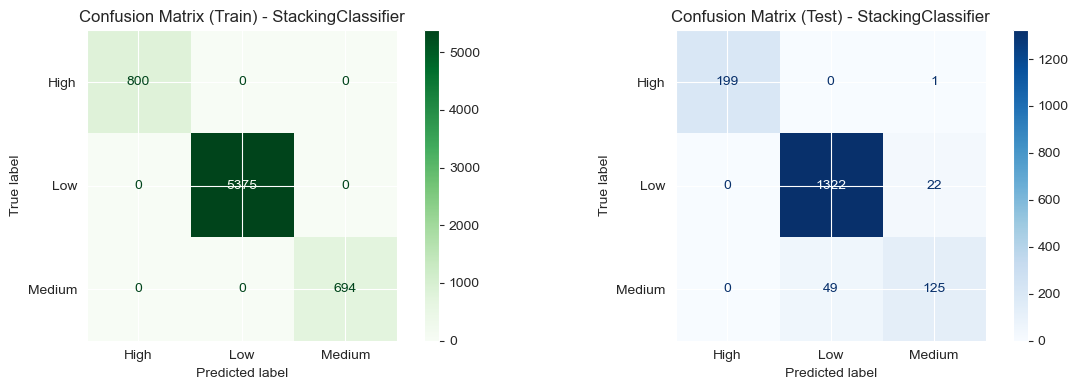

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=le_y.classes_)
disp_train.plot(ax=ax1, cmap='Greens', values_format='d')
ax1.set_title(f'Confusion Matrix (Train) - StackingClassifier')

cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=le_y.classes_)
disp_test.plot(ax=ax2, cmap='Blues', values_format='d')
ax2.set_title(f'Confusion Matrix (Test) - StackingClassifier')

plt.tight_layout()
plt.savefig('results/classification/enn/graphics/confusion_matrix.png', dpi=1000)
plt.show()

In [ ]:
# Save all preprocessing objects and model for production use
import joblib
import os

# Create output directory for model artifacts
output_dir = 'model'
os.makedirs(output_dir, exist_ok=True)

# Save the complete model pipeline artifacts
artifacts = {
    'model': best_model_obj,
    'scaler': scaler,
    'label_encoders': label_encoders,
    'target_encoder': le_y,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'feature_names': list(X_train.columns),
    'class_names': list(le_y.classes_)  # ['High', 'Low', 'Medium']
}

# Save all artifacts in a single file for easier loading
joblib.dump(artifacts, os.path.join(output_dir, 'enn_pipeline.pkl'))
print(f"✅ Saved complete pipeline to {output_dir}/enn_pipeline.pkl")

# Also save individual components for flexibility
joblib.dump(best_model_obj, os.path.join(output_dir, 'enn.pkl'))
joblib.dump(scaler, os.path.join(output_dir, 'scaler.pkl'))
joblib.dump(label_encoders, os.path.join(output_dir, 'label_encoders.pkl'))
joblib.dump(le_y, os.path.join(output_dir, 'target_encoder.pkl'))

# Save metadata
metadata = {
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'feature_names': list(X_train.columns),
    'class_names': list(le_y.classes_),
    'model_type': 'StackingClassifier',
    'version': '1.0'
}
joblib.dump(metadata, os.path.join(output_dir, 'metadata.pkl'))

print(f"✅ Saved individual components:")
print(f"   - {output_dir}/enn.pkl (model)")
print(f"   - {output_dir}/scaler.pkl")
print(f"   - {output_dir}/label_encoders.pkl")
print(f"   - {output_dir}/target_encoder.pkl")
print(f"   - {output_dir}/metadata.pkl")
print(f"\n📋 Feature names: {list(X_train.columns)}")
print(f"📋 Class names: {list(le_y.classes_)}")